<a href="https://colab.research.google.com/github/diidouu/SLAM-PROJECT/blob/main/projectRobotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bayesian Filtering Project : Simultaneous SLAM (Localization and Cartography) - EKF**
# 1. Problem definition :
The SLAM challenge can be seen as the *'chicken and egg problem'* :


*   To build a precise map of an unknown environment, a robot must know its position at each instant.
*   To locate itself with precision, a robot needs a precise map of the environment he is in.

SLAM consists in resolving these two problems in the same time. So, the goal is to estimate in real time an ***augmented state*** that contains :


*   The position and orientation of the robot (𝑥, 𝒚, θ)
*   The position of all static landmarks that the robot discovered ( (lx1,ly1), (lx2, ly2), ..).

This problem will be tackled with a 2D simulation in which a robot is equipped with captors that allow the robot to measure distance and angle with the landmark (this measures will be in interference with noise).

# 2. Algorithm and Development environment :

To resolve this non-linear estimation problem (trigonometry in movement and observation models are non-linear), we will use the ***Extended Kalman Filter (EKF)***. It is based on cycles of *Prediction - Correction* :


*   *Prediction* : The robot moves. Its new position is predicted thanks to the movement model. However, the likelihood decreases.
*   *Correction* : The robot observes one or several landmarks. This observation is used to correct the estimated position of the robot and landmarks in the *Prediction step.* If a new landmark is discovered, the map is dynamically extended. Thus, the likelihood increases.

The system state is described by a Gaussian distribution, defined by a state vector *μ* (this vector contains position and orientation of the landmarks) and a covariance matrix Σ that contains the likelihood and correlations between all state variables.

This project is developped in *Python3* in a *Google Colab notebook*. This environment has been chosen because of its set up simplicity and its visualization tools. The main libraries used are :


*   Numpy
*   Matplotlib





# **Step 1 - Creation of the virtual world and the simulation**
# Objective
Before estimating whatever we want, we need a perfect simulated environment with no noise. This environment will be our ***ground truth***. It will be our absolute reference which we will compare our filter's estimations performance with.
# Key components


1.   ***Landmarks*** : these are static points in our world. They will be really useful for localization. We define them as coordinates list (𝑥,𝑦).
2.   ***True trajectory of the robot*** : It is the exact path that the robot follows. We generate it by applying a perfect cinematic movement model thanks to control commands (linear velocity 𝑣 and angular velocity ω).
3. ***Perfect measures of captors*** : We simulate what captors would measure in an ideal situation/world. For each landmark, we calculate the exact euclidean distance and angle (with respect to the robot) by using simple geometric relations such *sqrt* and *arctan2*.

The visualization of these key components will give us a clear view of the simulation in which our EKF-SLAM will try to reconstruct from noisy data.



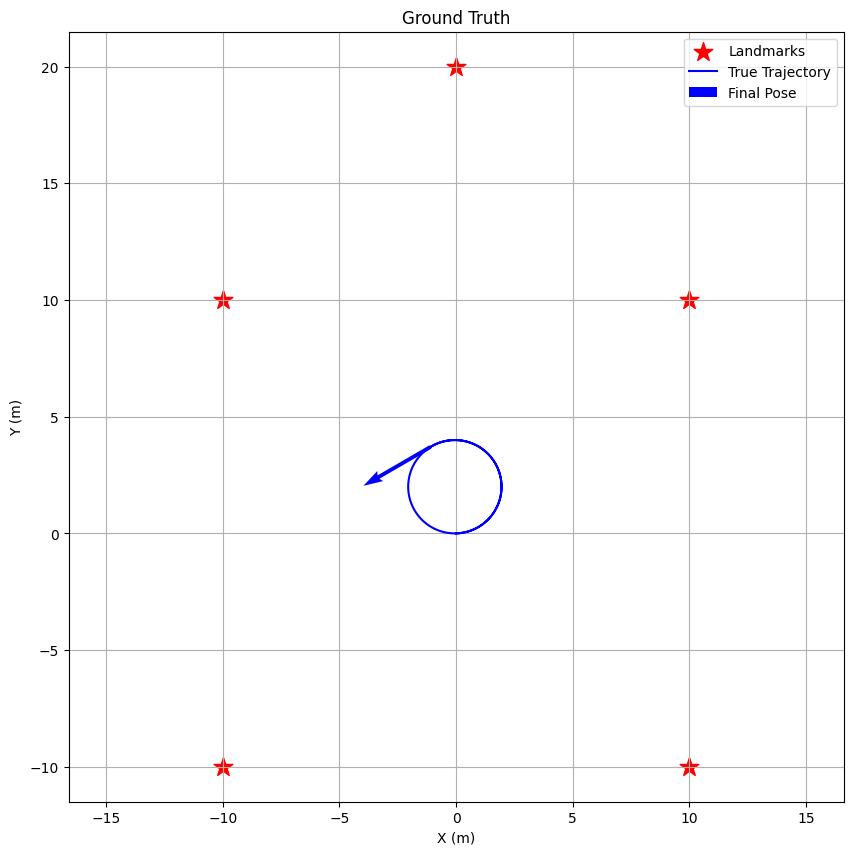

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1. Definition of landmarks position ---
# These are our reference points in the world.

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])


# --- 1.2. Definition of the true trajectory of the robot (Ground truth) ---
# This is the perfect path that the robot follows.

# Simulation parameters
dt = 0.1  # time interval (seconds)
SIMULATION_TIME = 20.0  # total duration of the simulation
NUM_STEPS = int(SIMULATION_TIME / dt)  # total number of simulation steps

# Trajectory storage
true_path = np.zeros((NUM_STEPS , 3))  # each line is [x , y , theta]
# initial position is (0 , 0 , 0)

# Constant control commands to create a circular trajectory
v = 1.0  # constant linear velocity (m/s)
omega = 0.5  # constant angular velocity (rad/s)

# Trajectory generation step by step
for t in range (1, NUM_STEPS):

  # Recover precedent position
  prev_x, prev_y, prev_theta = true_path[t-1]

  # Apply perfect cinematic movement model
  theta = prev_theta + omega * dt
  x = prev_x + v * np.cos(theta) * dt
  y = prev_y + v * np.sin(theta) * dt

  # Stock new true position
  true_path[t] = [x,y,theta]


  # --- 1.3. Simulation of the captors'perfect measures ---

  def get_true_measurement(robot_pose , landmarks) :

    """
    Calculate the perfect distance and angle of the robot to each landmarks
    """

    measurements = []
    rx , ry , rtheta = robot_pose

    for landmark in landmarks :
      lx, ly = landmark

      # Euclidean distance
      dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)

      # Angle to the landmark
      angle_to_landmark = np.arctan2(ly - ry, lx - rx)

      # Angle of the robot orientation (Bearing)
      bearing = angle_to_landmark - rtheta

      # Normalization of the bearing angle so it is in [-pi , +pi]
      bearing = (bearing + np.pi) % (2 * np.pi) - np.pi

      measurements.append([dist , bearing])

    return np.array(measurements)


# --- 1.4. Visualisation du monde simulé ---

def plot_world(path , lanfdmarks) :
  plt.figure(figsize=(10, 10))
  plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='Landmarks')
  plt.plot(path[:, 0], path[:, 1], 'b-', label='True Trajectory')

  # Draw an arrow to show final orientation of the robot
  final_pose = path[-1]
  plt.quiver(final_pose[0], final_pose[1], np.cos(final_pose[2]), np.sin(final_pose[2]),
               color='blue', scale=10, width=0.005, label='Final Pose')

  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')
  plt.title('Ground Truth')
  plt.grid(True)
  plt.axis('equal')
  plt.legend()
  plt.show()

# Display the world
plot_world(true_path , landmarks)

# **Step 2 : Uncertainties modelisation**
# Objective

Make our simulation as much realist as possible. In real life, actions and perceptions of the robot are imperfect. We will simulate these imperfections by introducing two types of *Gaussian noises* :



*   *Movement noise (on controls)* : Motors are not perfect. When a speed control is sent to the robot, it doesnt execute it perfectly. This provokes a position drift (the position which is estimated by odometry). We will simulate this by adding noises to the speed commands 𝑣 and ω.
*   *Measure noise (on captors)* : captors such as lasers, camera are not perfect. They provide measures with a certain amount of error. We will simulate this by adding noise to distance and angle measures to landmarks.

# What we will generate
In the end *(good music :p)*, we will end up with :


*   The true trajectory of *Step1*
*   *Odometric trajectory* : This is the trajectory that the robot thinks he moves along which is calculated with its noisy movement commands. We expect this trajectory to drift away from the true trajectory.
*  *Noisy measures* : Theses are the information that the filter will really receive from the environment.

Our filter job is to rebuild as close as possible the true trajectory with two information : the odometric trajectory and noisy measures.






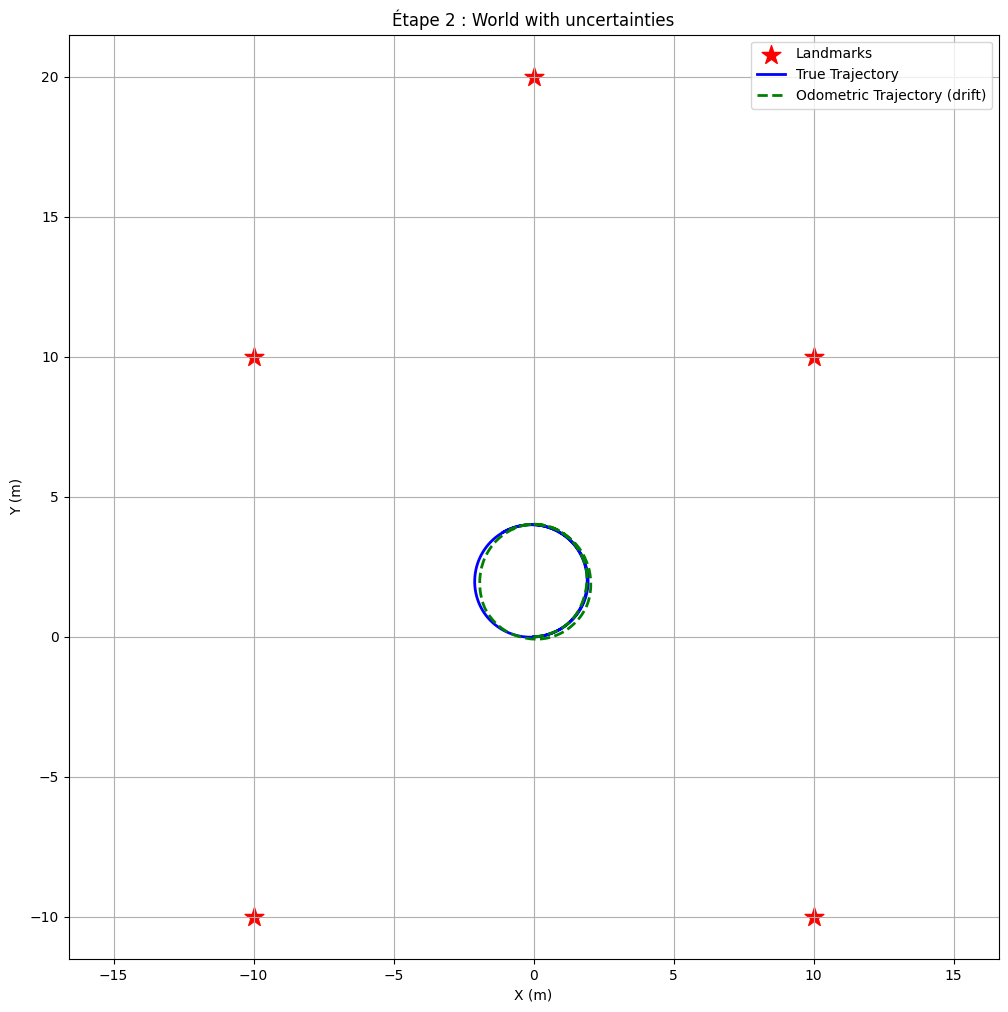

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1. Definition of landmarks position (from Step1) ---

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])

dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
v_ideal = 1.0
omega_ideal = 0.5

# --- 2. Definition of noisy models ---
#  Standard deviation of the Gaussian noise

MOTION_NOISE_STD = np.array([0.05 , 0.02])    # Noise on [v , omega]
MEASUREMENT_NOISE_STD = np.array([0.2 , 0.05])    # Noise on [distance , angle]

# --- 3. Generation of trajectories (True and Odometric) ---

true_path = np.zeros((NUM_STEPS , 3))
odometry_path = np.zeros((NUM_STEPS , 3))

for t in range (1 , NUM_STEPS) :

  # Simulate true commands affected by noise

  v_true_execution = v_ideal + np.random.randn() * MOTION_NOISE_STD[0]
  omega_true_execution = omega_ideal + np.random.randn() * MOTION_NOISE_STD[1]

  # Update true trajectory by using true execution commands

  prev_pose_true = true_path[t-1]
  theta_true = prev_pose_true[2] + omega_true_execution * dt

  true_path[t] = [
      prev_pose_true[0] + v_true_execution * np.cos(theta_true) * dt,
      prev_pose_true[1] + v_true_execution * np.sin(theta_true) * dt,
      theta_true
  ]

  # UPDATE ODOMETRIC TRAJECTORY

  # Odometry is the sum of the movements the robot thinks he has done.
  # We simulate that the odometry is measuring commands with its own amount of error.

  v_odom_measured = v_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[0]
  omega_odom_measured = omega_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[1]

  prev_pose_odom = odometry_path[t-1]
  theta_odom = prev_pose_odom[2] + omega_odom_measured * dt

  odometry_path[t] = [
      prev_pose_odom[0] + v_odom_measured * np.cos(theta_odom) * dt,
      prev_pose_odom[1] + v_odom_measured * np.sin(theta_odom) * dt,
      theta_odom
  ]

# --- 4. Function to generate noisy measures ---

def get_noisy_measurement(robot_pose , landmarks) :
  measurement = []
  rx , ry , rtheta = robot_pose

  for landmark in landmarks :
    lx , ly = landmark
    dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
    bearing = np.arctan2(ly - ry , lx - rx)

    noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
    noisy_bearing = bearing + np.random.randn() * MEASUREMENT_NOISE[1]
    noisy_bearing = (noisy_bearing + np.pi) % (2 * np.pi) - np.pi

    measurement.append([noisy_dist , noisy_bearing])

  return np.array(measurement)

# --- 5. Visualization of Step2 results ---

def plot_noisy_world(true_path, odometry_path, landmarks):
    plt.figure(figsize=(12, 12))
    plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='Landmarks')
    plt.plot(true_path[:, 0], true_path[:, 1], 'b-', linewidth=2, label='True Trajectory')
    plt.plot(odometry_path[:, 0], odometry_path[:, 1], 'g--', linewidth=2, label='Odometric Trajectory (drift)')

    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Étape 2 : World with uncertainties')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()

# Display
plot_noisy_world(true_path, odometry_path, landmarks)

# **Step 3 : Initialization of the filter's data structures**
# Objective

We will set up the fundamental matrices which will represent our filter's belief at each instant. In a Kalman filter, this belief is represented with a multidimensional Gaussian distribution which is defined as follows :


1.   ***Mean state vector (μ)*** : This is the best state estimation. It contains the most likely values of the robot and landmarks positions.
2.   ***Covariance matrix (Σ)*** : This is the monitoring core of incertainty. It quantifies uncertainty on each state variable and also correlations between uncertainties.
# Initialization

In the beginning (𝑡 = 0), the robot doesn't know the map.


*   The state vector **μ** only contains the initial pose of the robot (𝑥, 𝑦, θ). Its size is 3x1.
*   The covariance matrix **Σ** represents the uncertainty of this initial pose. Its size is 3x3. We will initialize it with zero uncertainty (a matrix full of zero) because we assume that the reobot knows perfectly its starting position.

As the robot discovers new landmarks, we will dynamically increase sizes of **μ** and **Σ**.





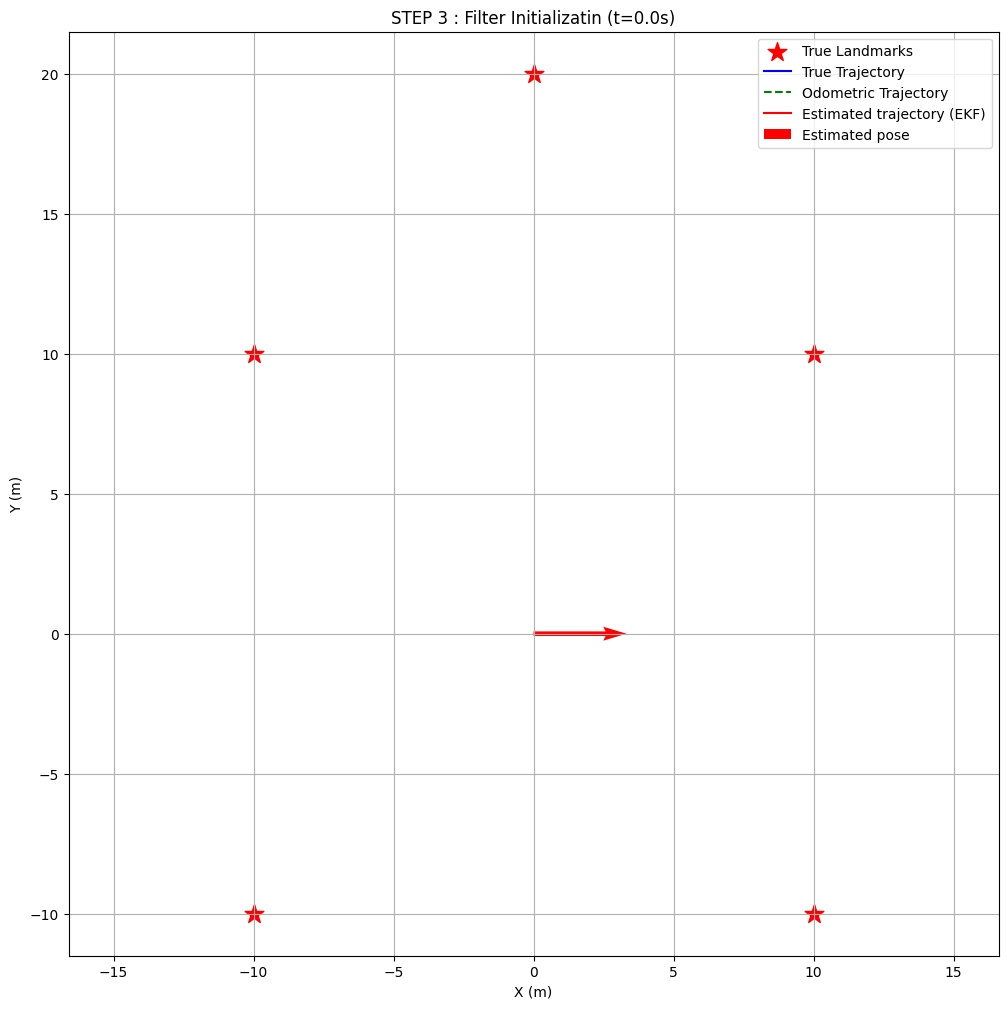

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

# --- 1.1. Definition of landmarks position (from Step1) ---

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])

dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
v_ideal = 1.0
omega_ideal = 0.5

# --- 2. Definition of noisy models (Unchanged) ---
#  Standard deviation of the Gaussian noise

MOTION_NOISE_STD = np.array([0.05 , 0.02])    # Noise on [v , omega]
MEASUREMENT_NOISE_STD = np.array([0.2 , 0.05])    # Noise on [distance , angle]

# --- 3. Generation of trajectories (True and Odometric) (Unchanged) ---

true_path = np.zeros((NUM_STEPS , 3))
odometry_path = np.zeros((NUM_STEPS , 3))

for t in range (1 , NUM_STEPS) :

  # Simulate true commands affected by noise

  v_true_execution = v_ideal + np.random.randn() * MOTION_NOISE_STD[0]
  omega_true_execution = omega_ideal + np.random.randn() * MOTION_NOISE_STD[1]

  # Update true trajectory by using true execution commands

  prev_pose_true = true_path[t-1]
  theta_true = prev_pose_true[2] + omega_true_execution * dt

  true_path[t] = [
      prev_pose_true[0] + v_true_execution * np.cos(theta_true) * dt,
      prev_pose_true[1] + v_true_execution * np.sin(theta_true) * dt,
      theta_true
  ]

  # UPDATE ODOMETRIC TRAJECTORY

  # Odometry is the sum of the movements the robot thinks he has done.
  # We simulate that the odometry is measuring commands with its own amount of error.

  v_odom_measured = v_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[0]
  omega_odom_measured = omega_ideal + np.random.randn() * MEASUREMENT_NOISE_STD[1]

  prev_pose_odom = odometry_path[t-1]
  theta_odom = prev_pose_odom[2] + omega_odom_measured * dt

  odometry_path[t] = [
      prev_pose_odom[0] + v_odom_measured * np.cos(theta_odom) * dt,
      prev_pose_odom[1] + v_odom_measured * np.sin(theta_odom) * dt,
      theta_odom
  ]

# --- 4. Initialisation of the EKF filtre ---

# State vector mu. Size = 3x1. In the beginning = [x , y , theta]
mu = np.zeros((3 , 1))

# Covariance matrix Sigma. Size = 3x3. In the beginning, full of zeros because the robot is perfectly aware of the starting position.
Sigma = np.zeros((3 , 3))

# History of estimations for the final plot
mu_history = [mu.copy()]
Sigma_history = [Sigma.copy()]

# --- 4. Upgraded functions for visualization ---

def plot_covariance_ellipse(mu_xy, sigma_xy, ax, color='r'):
    """Draws an uncertainty ellipse in 2D."""
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
    # 5.991 corresponds to a 95% confidence interval for a Chi-squared distribution with 2 degrees of freedom.
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ellipse = Ellipse(xy=mu_xy, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', alpha=0.6, linewidth=2)
    ax.add_patch(ellipse)



def plot_state(true_path, odometry_path, mu_history, Sigma_history, landmarks, step):
    """Displays the whole stateof a system at a given time."""
    mu = mu_history[step]
    Sigma = Sigma_history[step]

    fig, ax = plt.subplots(figsize=(12, 12))

    # Landmarks
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')

    # Trajectories
    ax.plot(true_path[:step+1, 0], true_path[:step+1, 1], 'b-', label='True Trajectory')
    ax.plot(odometry_path[:step+1, 0], odometry_path[:step+1, 1], 'g--', label='Odometric Trajectory')

    # Extract and draw the history of estimated positions
    est_path = np.array([h[:2, 0] for h in mu_history[:step+1]])
    ax.plot(est_path[:, 0], est_path[:, 1], 'r-', label='Estimated trajectory (EKF)')

    # Current estimated state of the robot
    robot_pose_est = mu[0:3]
    ax.quiver(robot_pose_est[0], robot_pose_est[1], np.cos(robot_pose_est[2]), np.sin(robot_pose_est[2]),
              color='r', scale=10, width=0.005, label='Estimated pose')

    # Robot uncertainty
    plot_covariance_ellipse(mu[0:2, 0], Sigma[0:2, 0:2], ax, color='r')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'STEP 3 : Filter Initializatin (t={(step)*dt:.1f}s)')
    ax.grid(True)
    ax.axis('equal')
    ax.legend()
    plt.show()


# --- 5. Execution ---
# For the moment, we don't have any for loop, so we visualize only the value when t=0
# History contains only one element for the moment
plot_state(true_path, odometry_path, mu_history, Sigma_history, landmarks, step=0)


# **Step 4 : Prediction step**
# Objective

The goal is to update filter's belief (μ and Σ) based only on the robot movement.
# How does it work?


1.   Update of μ

*   We apply the movement model to the part 'robot pose' of μ.



2.   Update of Σ

*   Σ is 'deformed' by the non-linear movement of the robot. We get this deformation effect with the ***Jacobian G***.
*   A new uncertainty is added due to the noise movement. We modelize this with a ***movement matrix R***.





Step 4 simulation finished. Prediction history has been generated.


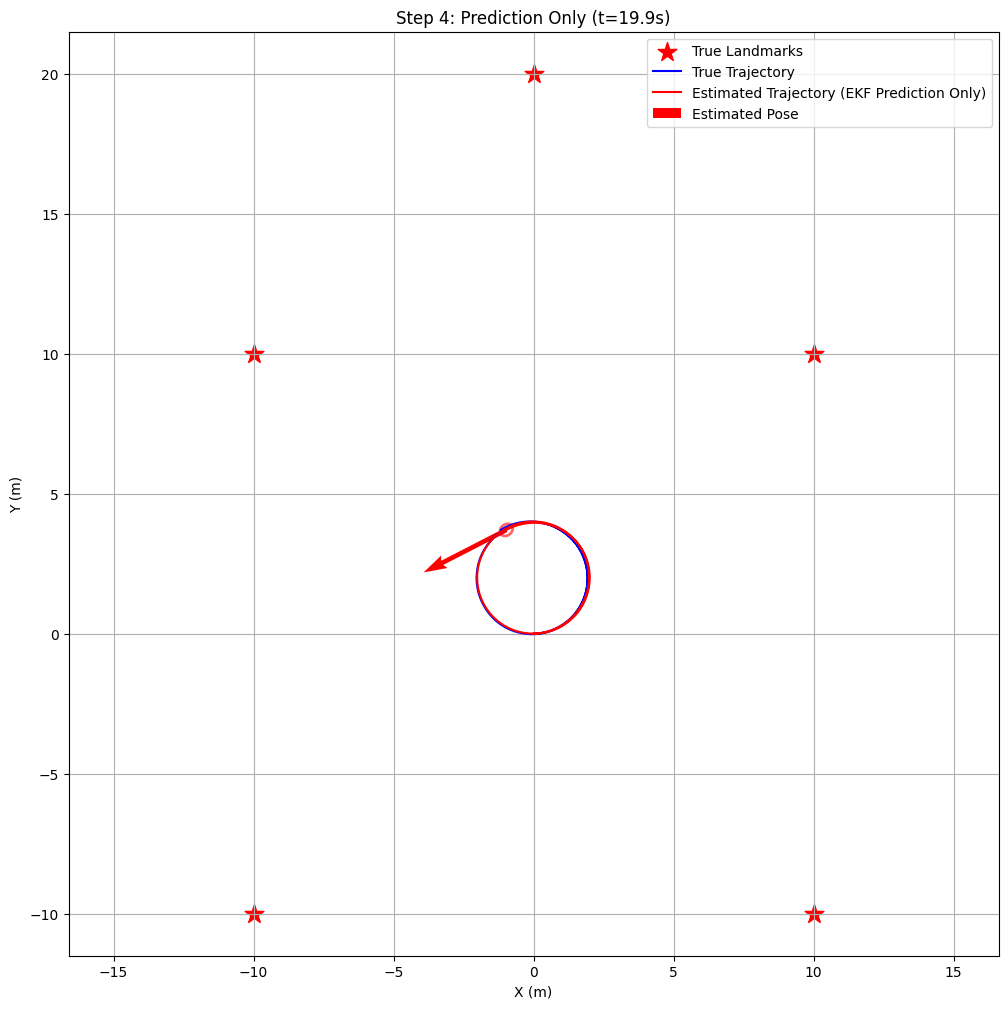

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

# --- 1. Parameters ---
landmarks = np.array([
    [10.0, 10.0], [10.0, -10.0], [-10.0, 10.0],
    [-10.0, -10.0], [0.0, 20.0]
])
dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
ideal_v = 1.0
ideal_omega = 0.5
MOTION_NOISE_STD = np.array([0.05, 0.02])
MEASUREMENT_NOISE_STD = np.array([0.2, 0.05])

# --- 2. Noisy World Simulation ---
true_path = np.zeros((NUM_STEPS, 3))
odometry_path = np.zeros((NUM_STEPS, 3))
odom_controls = np.zeros((NUM_STEPS, 2)) # [v, omega]

for t in range(1, NUM_STEPS):
    # Simulate the true executed motion
    true_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]
    true_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]

    # Update true path
    prev_true_pose = true_path[t-1]
    true_theta = prev_true_pose[2] + true_omega * dt
    true_path[t] = [
        prev_true_pose[0] + true_v * np.cos(true_theta) * dt,
        prev_true_pose[1] + true_v * np.sin(true_theta) * dt,
        true_theta ]

    # Simulate the measured odometry
    measured_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]
    measured_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    odom_controls[t] = [measured_v, measured_omega]

    # Update odometry path
    prev_odom_pose = odometry_path[t-1]
    odom_theta = prev_odom_pose[2] + measured_omega * dt
    odometry_path[t] = [
        prev_odom_pose[0] + measured_v * np.cos(odom_theta) * dt,
        prev_odom_pose[1] + measured_v * np.sin(odom_theta) * dt,
        odom_theta ]

# --- 3. EKF Prediction Function ---
def prediction_step(mu, Sigma, control):
    """
    Performs the EKF prediction step.
    - mu: Current state vector
    - Sigma: Current covariance matrix
    - control: Motion command [v, omega]
    """
    v = control[0]
    omega = control[1]

    # Extract current robot pose from state
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]

    # --- Update the state vector mu ---
    # Apply motion model to our best estimate
    mu[0, 0] = x + v * np.cos(theta + omega * dt) * dt
    mu[1, 0] = y + v * np.sin(theta + omega * dt) * dt
    mu[2, 0] = theta + omega * dt

    # --- Update the covariance matrix Sigma ---
    # Calculate the Jacobian G of the motion model w.r.t. the robot pose
    # G is the partial derivative of the new pose w.r.t. the old pose
    G = np.array([
        [1, 0, -v * np.sin(theta + omega * dt) * dt],
        [0, 1,  v * np.cos(theta + omega * dt) * dt],
        [0, 0,  1]
    ])

    # Motion noise covariance matrix R
    # Represents the uncertainty added by the movement itself.
    R = np.diag([
        (MOTION_NOISE_STD[0] * dt)**2,
        (MOTION_NOISE_STD[0] * dt)**2,
        (MOTION_NOISE_STD[1] * dt)**2
    ])

    # Apply the covariance propagation formula
    Sigma = G @ Sigma @ G.T + R

    return mu, Sigma

# --- 4. Simulation Loop with the Filter ---
# Initialize filter state
mu = np.zeros((3, 1))
Sigma = np.zeros((3, 3))
# History for plotting
mu_history = [mu.copy()]
Sigma_history = [Sigma.copy()]

# Main loop
for t in range(1, NUM_STEPS):
    # Get the measured control for this time step
    control = odom_controls[t]

    # Call the prediction step
    mu, Sigma = prediction_step(mu, Sigma, control)

    # Store results
    mu_history.append(mu.copy())
    Sigma_history.append(Sigma.copy())

print("Step 4 simulation finished. Prediction history has been generated.")


# --- 5. Visualization ---
# Utility functions
def plot_covariance_ellipse(mu_xy, sigma_xy, ax, color='r'):
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if np.any(eigenvalues < 0): return
    angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues) # 95% confidence interval
    ellipse = Ellipse(xy=mu_xy, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', alpha=0.6, linewidth=2)
    ax.add_patch(ellipse)

def plot_state(true_path, odom_path, mu_history, Sigma_history, landmarks, step):
    mu = mu_history[step]
    Sigma = Sigma_history[step]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')
    ax.plot(true_path[:, 0], true_path[:, 1], 'b-', label='True Trajectory')

    # Extract and plot the estimated path history
    est_path = np.array([h[:2, 0] for h in mu_history])
    ax.plot(est_path[:, 0], est_path[:, 1], 'r-', label='Estimated Trajectory (EKF Prediction Only)')

    # Current estimated robot pose
    robot_pose_est = mu[0:3]
    ax.quiver(robot_pose_est[0], robot_pose_est[1], np.cos(robot_pose_est[2]), np.sin(robot_pose_est[2]),
              color='r', scale=10, width=0.005, label='Estimated Pose')
    # Plot robot uncertainty
    plot_covariance_ellipse(mu[0:2, 0], Sigma[0:2, 0:2], ax, color='r')

    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
    ax.set_title(f'Step 4: Prediction Only (t={(step)*dt:.1f}s)')
    ax.grid(True); ax.axis('equal'); ax.legend(); plt.show()

# Display the result at the end of the simulation
plot_state(true_path, odometry_path, mu_history, Sigma_history, landmarks, step=NUM_STEPS-1)

# **Step 5 : Correction step**
# Objective
To correct the predicted belief **(μ_bar, Σ_bar)** using a sensor measurement. This is where the robot says: "I predicted I'd be here, but my sensor sees landmark #J at this distance and angle. I'll use this information to correct my belief about my own pose and the landmark's position."
# How does it work?

For each landmark j observed at time t :


1.   ***Check if Landmark is New***: For now, we'll assume we know which landmark we are seeing and that it's already in our state vector. We'll handle new landmarks in the next step.

2.  ***Compute Predicted Measurement (z_hat)***: Based on the predicted robot pose (μ_bar) and the estimated position of landmark j in our state vector, what measurement (distance, bearing) did we expect to see?
2.   ***Compute the Measurement Jacobian (H)***: This matrix represents the partial derivative of the observation model with respect to the state (robot pose and landmark position). It linearizes the non-linear observation model around the current state estimate.
3.  ***Compute the Kalman Gain (K)***: This crucial gain determines how much we trust the new measurement compared to our prediction. If our prediction is very uncertain but our sensor is precise, K will be high (we trust the measurement a lot). If our prediction is certain and our sensor is noisy, K will be low (we mostly stick to our prediction).
4.  ***Update the State Vector (μ)***: The new state is a combination of the predicted state and the "innovation" (the difference between the actual measurement z and the predicted measurement z_hat), weighted by the Kalman Gain K. μ = μ_bar + K * (z - z_hat)
5.  ***Update the Covariance Matrix (Σ)***: The covariance is updated to reflect the reduction in uncertainty. Σ = (I - K * H) * Σ_bar



Simulation de l'étape 5 (version originale) terminée.


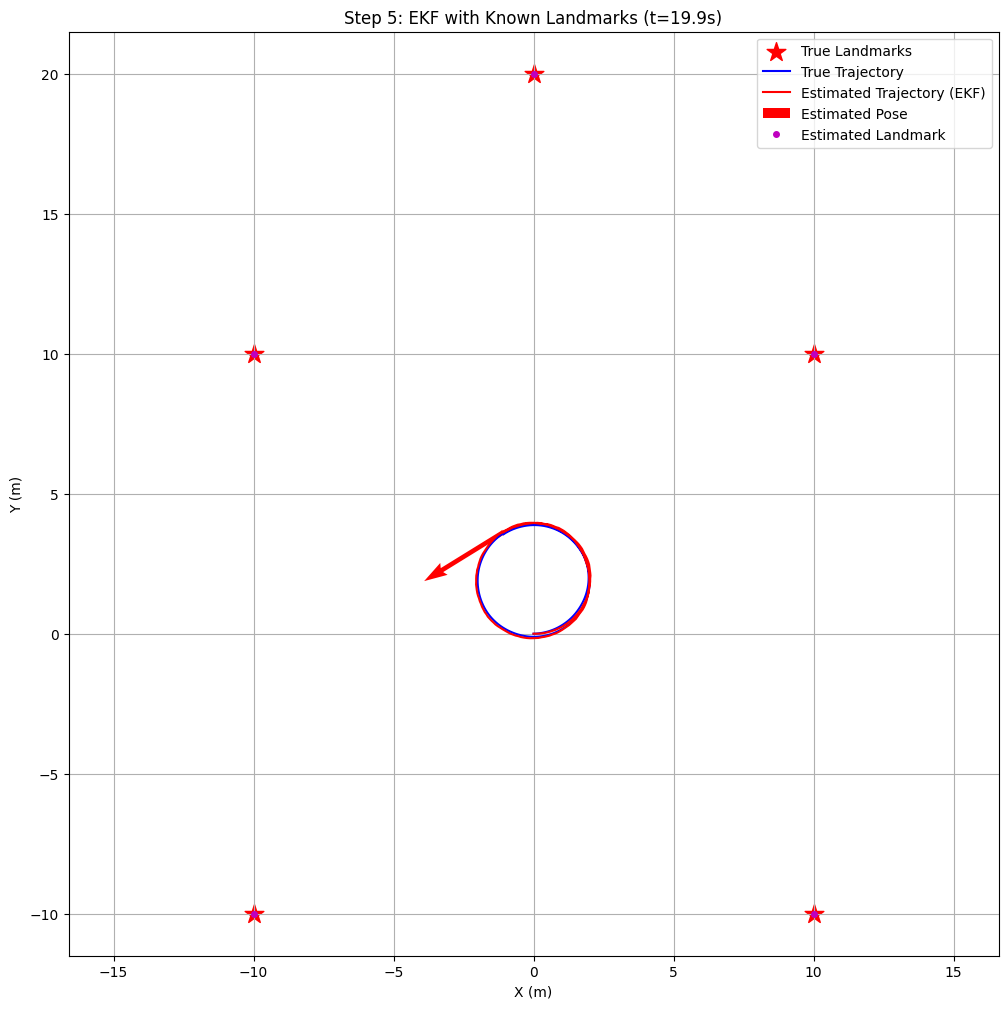

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

# --- 1. Parameters ---
landmarks = np.array([
    [10.0, 10.0], [10.0, -10.0], [-10.0, 10.0],
    [-10.0, -10.0], [0.0, 20.0]
])
NUM_LANDMARKS = landmarks.shape[0]
dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
ideal_v = 1.0
ideal_omega = 0.5
MOTION_NOISE_STD = np.array([0.05, 0.02])
MEASUREMENT_NOISE_STD = np.array([0.2, 0.05])

# --- Helper function for normalizing angles ---
def normalize_angle(angle):
    """Normalize an angle to the range [-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

# --- 2. Simulation of the noisy world ---
true_path = np.zeros((NUM_STEPS, 3))
odom_controls = np.zeros((NUM_STEPS, 2))
for t in range(1, NUM_STEPS):
    true_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]
    true_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]
    true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt,
                     prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]
    measured_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]
    measured_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    odom_controls[t] = [measured_v, measured_omega]

# **** FONCTION MANQUANTE AJOUTÉE ICI ****
def get_noisy_measurements(robot_pose_true, landmarks):
    measurements = []
    rx, ry, rtheta = robot_pose_true
    for landmark in landmarks:
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
        noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
        noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
        measurements.append([noisy_dist, noisy_bearing])
    return np.array(measurements)

# --- 3. EKF Functions ---
def prediction_step(mu, Sigma, control):
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]
    v, omega = control[0], control[1]

    mu_pred = mu.copy()
    mu_pred[0, 0] = x + v * np.cos(theta) * dt
    mu_pred[1, 0] = y + v * np.sin(theta) * dt
    mu_pred[2, 0] = normalize_angle(theta + omega * dt)

    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt],
                        [0, 1,  v * np.cos(theta) * dt],
                        [0, 0,  1]])
    G = np.eye(len(mu))
    G[0:3, 0:3] = G_robot

    R_robot = np.diag([MOTION_NOISE_STD[0]**2, MOTION_NOISE_STD[0]**2, MOTION_NOISE_STD[1]**2]) * dt**2
    R = np.zeros_like(Sigma)
    R[0:3, 0:3] = R_robot

    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

def correction_step(mu_pred, Sigma_pred, measurement, landmark_index):
    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx, ly = mu_pred[3 + 2 * landmark_index, 0], mu_pred[3 + 2 * landmark_index + 1, 0]

    delta_x, delta_y = lx - x_pred, ly - y_pred
    q = delta_x**2 + delta_y**2
    if q < 1e-4:
        return mu_pred, Sigma_pred

    dist_pred = np.sqrt(q)
    bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])

    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0],
                        [ delta_y/q,         -delta_x/q,        -1]])
    H_landmark = np.array([[delta_x/dist_pred,  delta_y/dist_pred],
                           [-delta_y/q,          delta_x/q]])

    H = np.zeros((2, len(mu_pred)))
    H[:, 0:3] = H_robot
    H[:, 3 + 2*landmark_index : 3 + 2*landmark_index + 2] = H_landmark

    Q = np.diag(MEASUREMENT_NOISE_STD**2)
    S = H @ Sigma_pred @ H.T + Q
    K = Sigma_pred @ H.T @ np.linalg.inv(S)

    innovation = measurement.reshape(2, 1) - z_hat
    innovation[1, 0] = normalize_angle(innovation[1, 0])

    mu_new = mu_pred + K @ innovation
    mu_new[2,0] = normalize_angle(mu_new[2,0])

    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred

    return mu_new, Sigma_new

# --- 4. Simulation Loop with the FULL Filter ---
mu = np.zeros((3 + 2 * NUM_LANDMARKS, 1))
mu[3:] = landmarks.flatten().reshape(-1, 1)
Sigma = np.zeros((3 + 2 * NUM_LANDMARKS, 3 + 2 * NUM_LANDMARKS))
np.fill_diagonal(Sigma[3:], 1e-6)

mu_history = [mu.copy()]
Sigma_history = [Sigma.copy()]

for t in range(1, NUM_STEPS):
    control = odom_controls[t]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], control)

    # La fonction est maintenant définie, donc cet appel fonctionnera
    measurements = get_noisy_measurements(true_path[t], landmarks)

    mu_corrected, Sigma_corrected = mu_pred, Sigma_pred
    for i in range(NUM_LANDMARKS):
        mu_corrected, Sigma_corrected = correction_step(mu_corrected, Sigma_corrected, measurements[i], i)

    mu_history.append(mu_corrected.copy())
    Sigma_history.append(Sigma_corrected.copy())

print("Simulation de l'étape 5 (version originale) terminée.")

# --- 5. Visualization ---
def plot_covariance_ellipse(mu_xy, sigma_xy, ax, color='r'):
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if np.any(eigenvalues < 0): return
    angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ellipse = Ellipse(xy=mu_xy, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor='none', alpha=0.6, linewidth=1)
    ax.add_patch(ellipse)

def plot_final_state(true_path, mu_history, Sigma_history, landmarks, step):
    mu = mu_history[step]
    Sigma = Sigma_history[step]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')

    ax.plot(true_path[:, 0], true_path[:, 1], 'b-', label='True Trajectory')
    est_path = np.array([h[:2, 0] for h in mu_history])
    ax.plot(est_path[:, 0], est_path[:, 1], 'r-', label='Estimated Trajectory (EKF)')

    robot_pose_est = mu[0:3]
    ax.quiver(robot_pose_est[0], robot_pose_est[1], np.cos(robot_pose_est[2]), np.sin(robot_pose_est[2]),
              color='r', scale=10, width=0.005, label='Estimated Pose')
    plot_covariance_ellipse(mu[0:2, 0], Sigma[0:2, 0:2], ax, color='r')

    for i in range(NUM_LANDMARKS):
        landmark_mu = mu[3 + 2*i : 3 + 2*i + 2, 0]
        landmark_Sigma = Sigma[3 + 2*i : 3 + 2*i + 2, 3 + 2*i : 3 + 2*i + 2]
        ax.plot(landmark_mu[0], landmark_mu[1], 'mo', markersize=4, label='Estimated Landmark' if i == 0 else "")
        plot_covariance_ellipse(landmark_mu, landmark_Sigma, ax, color='m')

    # Retrait de odom_path de l'appel, car on ne l'utilise plus dans cette fonction
    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
    ax.set_title(f'Step 5: EKF with Known Landmarks (t={(step)*dt:.1f}s)')
    ax.grid(True); ax.axis('equal'); ax.legend(); plt.show()

# L'appel à la fonction de plot ne nécessite plus odom_path
plot_final_state(true_path, mu_history, Sigma_history, landmarks, step=NUM_STEPS-1)

# ***Step 6: Handling Unknown Landmarks (SLAM)***
# Objective

To remove the major simplification from Step 5. Now, the filter will start without knowing the position of any landmarks. It must build the map itself. This is what turns "localization" into "SLAM".

# How does it work?
The prediction-correction cycle remains the same, but the correction step becomes smarter. For each measurement, the filter must first ask: "Is this landmark I'm seeing one I already know, or is it a new one?" This is the data association problem.

---
For this project, we will use a simple method:


1.   ***Initialization***: The filter starts with a state containing only the robot's pose. The map is empty.
2.   ***First Observation of a Landmark***: When a landmark is seen for the first time, we cannot use it to correct the robot's pose (since its position is unknown). Instead, we use the measurement to initialize this landmark in our map. We augment the size of the state vector μ and the covariance matrix Σ to include the estimated position of this new landmark.
3.  ***Re-observation of a Known Landmark***: When the robot observes a landmark that is already in its map, it performs a normal correction step, just like in Step 5. This correction will update both the robot's pose and the observed landmark's position, tightening the uncertainty on both.




Step 6 (SLAM) simulation finished.


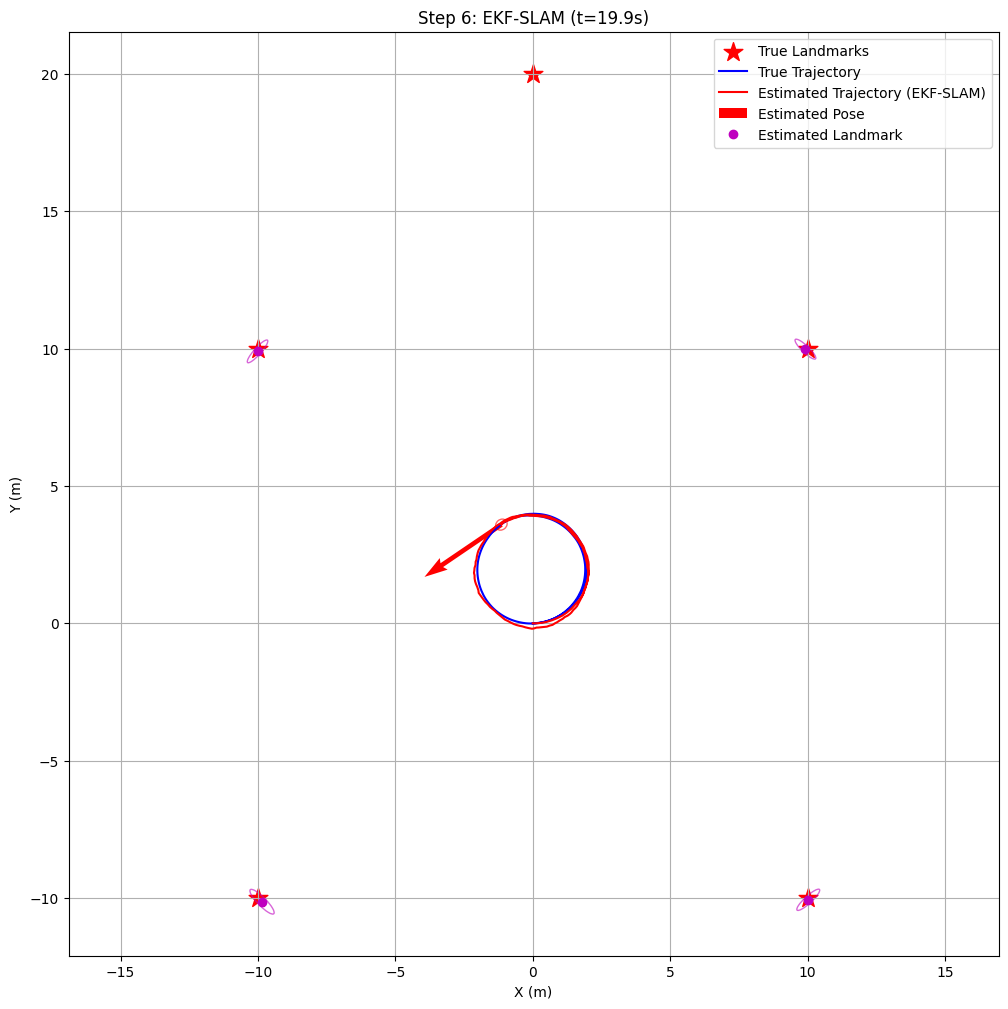

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math

# --- 1. Parameters ---
landmarks = np.array([
    [10.0, 10.0], [10.0, -10.0], [-10.0, 10.0],
    [-10.0, -10.0], [0.0, 20.0]
])
NUM_LANDMARKS = landmarks.shape[0]
dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
ideal_v = 1.0
ideal_omega = 0.5
MOTION_NOISE_STD = np.array([0.1, 0.05])
MEASUREMENT_NOISE_STD = np.array([0.3, 0.08])

# --- Helper functions ---
def normalize_angle(angle):
    """Normalize an angle to the range [-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_noisy_measurements(robot_pose_true, landmarks):
    """Simulates sensor measurements with a limited field of view."""
    VISIBLE_DISTANCE = 15.0
    measurements = []
    visible_landmark_indices = []
    rx, ry, rtheta = robot_pose_true

    for i, landmark in enumerate(landmarks):
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        if dist <= VISIBLE_DISTANCE:
            bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
            noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
            noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
            measurements.append(np.array([noisy_dist, noisy_bearing]))
            visible_landmark_indices.append(i)
    return measurements, visible_landmark_indices

# --- 2. Noisy World Simulation ---
true_path = np.zeros((NUM_STEPS, 3))
odom_controls = np.zeros((NUM_STEPS, 2))
for t in range(1, NUM_STEPS):
    true_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]; true_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]; true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt, prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]
    measured_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]; measured_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    odom_controls[t] = [measured_v, measured_omega]

# --- 3. EKF-SLAM Functions ---
def prediction_step(mu, Sigma, control):
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]; v, omega = control[0], control[1]

    mu_pred = mu.copy()
    mu_pred[0, 0] = x + v * np.cos(theta) * dt
    mu_pred[1, 0] = y + v * np.sin(theta) * dt
    mu_pred[2, 0] = normalize_angle(theta + omega * dt)

    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt], [0, 1, v * np.cos(theta) * dt], [0, 0, 1]])
    G = np.eye(len(mu)); G[0:3, 0:3] = G_robot

    motion_cov = np.diag([MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[1]**2 * dt**2])
    R = np.zeros_like(Sigma)
    R[0:3, 0:3] = motion_cov

    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

# NEW FUNCTION: Augments the state when a new landmark is seen
def add_new_landmark_to_state(mu, Sigma, measurement, Q_measurement_noise):
    rx, ry, theta = mu[0:3].flatten()
    r, b = measurement[0], measurement[1]

    # Estimated coordinates of the new landmark
    lx = rx + r * np.cos(b + theta)
    ly = ry + r * np.sin(b + theta)

    # Augment state vector
    mu_new = np.vstack((mu, [[lx], [ly]]))

    # Jacobian of the inverse observation model
    G_z = np.array([[np.cos(b + theta), -r * np.sin(b + theta)],
                    [np.sin(b + theta),  r * np.cos(b + theta)]])

    # Augment covariance matrix
    old_size = len(mu)
    Sigma_new = np.zeros((old_size + 2, old_size + 2))
    Sigma_new[:old_size, :old_size] = Sigma

    # Covariance of the new landmark
    Sigma_new[old_size:, old_size:] = G_z @ Q_measurement_noise @ G_z.T

    return mu_new, Sigma_new

def correction_step(mu_pred, Sigma_pred, measurement, landmark_map_index):

    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx = mu_pred[3 + 2 * landmark_map_index, 0]; ly = mu_pred[3 + 2 * landmark_map_index + 1, 0]

    delta_x, delta_y = lx - x_pred, ly - y_pred; q = delta_x**2 + delta_y**2
    if q < 1e-4: return mu_pred, Sigma_pred

    dist_pred = np.sqrt(q); bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])

    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0], [delta_y/q, -delta_x/q, -1]])
    H_landmark = np.array([[delta_x/dist_pred, delta_y/dist_pred], [-delta_y/q, delta_x/q]])

    H = np.zeros((2, len(mu_pred))); H[:, 0:3] = H_robot; H[:, 3 + 2*landmark_map_index : 3 + 2*landmark_map_index + 2] = H_landmark

    Q = np.diag(MEASUREMENT_NOISE_STD**2); S = H @ Sigma_pred @ H.T + Q; K = Sigma_pred @ H.T @ np.linalg.inv(S)

    innovation = measurement.reshape(2, 1) - z_hat; innovation[1, 0] = normalize_angle(innovation[1, 0])

    mu_new = mu_pred + K @ innovation; mu_new[2,0] = normalize_angle(mu_new[2,0])
    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred
    return mu_new, Sigma_new

# --- 4. SLAM Simulation Loop ---
# Initialize filter: MAP IS EMPTY!
mu = np.zeros((3, 1))
Sigma = np.diag([1e-10, 1e-10, 1e-10]) # Tiny non-zero initial uncertainty for stability
mu_history = [mu.copy()]
Sigma_history = [Sigma.copy()]

# To keep track of which landmarks are in our state vector
landmark_map = {} # Dictionary: {true_landmark_id: index_in_mu}
next_map_index = 0

for t in range(1, NUM_STEPS):
    control = odom_controls[t]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], control)

    measurements, visible_indices = get_noisy_measurements(true_path[t], landmarks)

    mu_after_correction, Sigma_after_correction = mu_pred, Sigma_pred

    for i, meas in enumerate(measurements):
        landmark_id = visible_indices[i]

        if landmark_id not in landmark_map:
            # First time seeing this landmark: add it to the map
            mu_after_correction, Sigma_after_correction = add_new_landmark_to_state(mu_after_correction, Sigma_after_correction, meas, np.diag(MEASUREMENT_NOISE_STD**2))
            landmark_map[landmark_id] = next_map_index
            next_map_index += 1
        else:
            # Landmark is already known: perform a correction step
            map_idx = landmark_map[landmark_id]
            mu_after_correction, Sigma_after_correction = correction_step(mu_after_correction, Sigma_after_correction, meas, map_idx)

    mu_history.append(mu_after_correction.copy())
    Sigma_history.append(Sigma_after_correction.copy())

print("Step 6 (SLAM) simulation finished.")

# --- 5. Visualization ---
def plot_covariance_ellipse(mu_xy, sigma_xy, ax, color='r'):
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if np.any(eigenvalues < 0): return
    angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(5.991 * eigenvalues)
    ellipse = Ellipse(xy=mu_xy, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', alpha=0.6, linewidth=1)
    ax.add_patch(ellipse)

def plot_final_state(true_path, mu_history, Sigma_history, landmarks, step):
    mu = mu_history[step]; Sigma = Sigma_history[step]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')
    ax.plot(true_path[:, 0], true_path[:, 1], 'b-', label='True Trajectory')
    est_path = np.array([h[:2, 0] for h in mu_history]); ax.plot(est_path[:, 0], est_path[:, 1], 'r-', label='Estimated Trajectory (EKF-SLAM)')

    robot_pose_est = mu[0:3]; ax.quiver(robot_pose_est[0], robot_pose_est[1], np.cos(robot_pose_est[2]), np.sin(robot_pose_est[2]), color='r', scale=10, width=0.005, label='Estimated Pose')
    plot_covariance_ellipse(mu[0:2, 0], Sigma[0:2, 0:2], ax, color='r')

    num_landmarks_in_map = (len(mu) - 3) // 2
    for i in range(num_landmarks_in_map):
        landmark_mu = mu[3 + 2*i : 3 + 2*i + 2, 0]
        landmark_Sigma = Sigma[3 + 2*i : 3 + 2*i + 2, 3 + 2*i : 3 + 2*i + 2]
        ax.plot(landmark_mu[0], landmark_mu[1], 'mo', markersize=6, label='Estimated Landmark' if i == 0 else "")
        plot_covariance_ellipse(landmark_mu, landmark_Sigma, ax, color='m')

    ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_title(f'Step 6: EKF-SLAM (t={(step)*dt:.1f}s)')
    ax.grid(True); ax.axis('equal'); ax.legend(); plt.show()

plot_final_state(true_path, mu_history, Sigma_history, landmarks, step=NUM_STEPS-1)

# ***Step 7: Final Visualization and Analysis***
# Objective

To produce the dynamic results required for the project submission. A static image at the end is good, but an animation showing the process step-by-step is far more compelling. We will create a video that shows:



1.   The robot moving along its path.
2.   The estimated map being built landmark by landmark as they are discovered.
3.  The uncertainty ellipses (for both the robot and landmarks) evolving in real-time: growing during prediction and shrinking during correction.

# How does it work?

We will use the FuncAnimation tool from matplotlib.animation. The process is as follows:


1.   Set up a plot figure and its elements (lines, patches for ellipses, etc.) that will be updated.

1.   Define an update function that takes a frame number t as input.
2.   Inside update, we will clear the previous drawing and redraw the state of the world at time t using the data we stored in mu_history and Sigma_history.


2.   FuncAnimation will then call this update function repeatedly for each time step, creating a sequence of images.
1.  This sequence is then encoded into a video file (e.g., .mp4) and displayed directly in the Colab notebook.





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML # To display the animation in Colab

# --- 1. Parameters ---
landmarks = np.array([
    [10.0, 10.0], [10.0, -10.0], [-10.0, 10.0],
    [-10.0, -10.0], [0.0, 20.0]
])
NUM_LANDMARKS = landmarks.shape[0]
dt = 0.1
SIMULATION_TIME = 20.0
NUM_STEPS = int(SIMULATION_TIME / dt)
ideal_v = 1.0
ideal_omega = 0.5
MOTION_NOISE_STD = np.array([0.1, 0.05])
MEASUREMENT_NOISE_STD = np.array([0.3, 0.08])

# --- Helper functions ---
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_noisy_measurements(robot_pose_true, landmarks):
    VISIBLE_DISTANCE = 15.0
    measurements = []; visible_landmark_indices = []
    rx, ry, rtheta = robot_pose_true
    for i, landmark in enumerate(landmarks):
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        if dist <= VISIBLE_DISTANCE:
            bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
            noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
            noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
            measurements.append(np.array([noisy_dist, noisy_bearing]))
            visible_landmark_indices.append(i)
    return measurements, visible_landmark_indices

# --- 2. Simulation ---
true_path = np.zeros((NUM_STEPS, 3)); odom_controls = np.zeros((NUM_STEPS, 2))
for t in range(1, NUM_STEPS):
    true_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]; true_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]; true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt, prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]
    measured_v = ideal_v + np.random.randn() * MOTION_NOISE_STD[0]; measured_omega = ideal_omega + np.random.randn() * MOTION_NOISE_STD[1]
    odom_controls[t] = [measured_v, measured_omega]

# --- 3. EKF-SLAM Functions ---
def prediction_step(mu, Sigma, control):
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]; v, omega = control[0], control[1]
    mu_pred = mu.copy(); mu_pred[0, 0] = x + v * np.cos(theta) * dt; mu_pred[1, 0] = y + v * np.sin(theta) * dt; mu_pred[2, 0] = normalize_angle(theta + omega * dt)
    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt], [0, 1, v * np.cos(theta) * dt], [0, 0, 1]])
    G = np.eye(len(mu)); G[0:3, 0:3] = G_robot
    motion_cov = np.diag([MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[1]**2 * dt**2])
    R = np.zeros_like(Sigma); R[0:3, 0:3] = motion_cov
    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

def add_new_landmark_to_state(mu, Sigma, measurement, Q_measurement_noise):
    rx, ry, theta = mu[0:3].flatten(); r, b = measurement[0], measurement[1]
    lx = rx + r * np.cos(b + theta); ly = ry + r * np.sin(b + theta)
    mu_new = np.vstack((mu, [[lx], [ly]]))
    G_z = np.array([[np.cos(b + theta), -r * np.sin(b + theta)], [np.sin(b + theta),  r * np.cos(b + theta)]])
    old_size = len(mu); Sigma_new = np.zeros((old_size + 2, old_size + 2)); Sigma_new[:old_size, :old_size] = Sigma
    Sigma_new[old_size:, :3] = -G_z @ Sigma[:2, :3]; # A more stable formulation involves G_robot
    Sigma_new[:3, old_size:] = Sigma_new[old_size:, :3].T
    Sigma_new[old_size:, old_size:] = G_z @ Q_measurement_noise @ G_z.T
    return mu_new, Sigma_new

def correction_step(mu_pred, Sigma_pred, measurement, landmark_map_index):
    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx = mu_pred[3 + 2 * landmark_map_index, 0]; ly = mu_pred[3 + 2 * landmark_map_index + 1, 0]
    delta_x, delta_y = lx - x_pred, ly - y_pred; q = delta_x**2 + delta_y**2
    if q < 1e-4: return mu_pred, Sigma_pred
    dist_pred = np.sqrt(q); bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])
    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0], [delta_y/q, -delta_x/q, -1]])
    H_landmark = np.array([[delta_x/dist_pred, delta_y/dist_pred], [-delta_y/q, delta_x/q]])
    H = np.zeros((2, len(mu_pred))); H[:, 0:3] = H_robot; H[:, 3 + 2*landmark_map_index : 3 + 2*landmark_map_index + 2] = H_landmark
    Q = np.diag(MEASUREMENT_NOISE_STD**2); S = H @ Sigma_pred @ H.T + Q; K = Sigma_pred @ H.T @ np.linalg.inv(S)
    innovation = measurement.reshape(2, 1) - z_hat; innovation[1, 0] = normalize_angle(innovation[1, 0])
    mu_new = mu_pred + K @ innovation; mu_new[2,0] = normalize_angle(mu_new[2,0])
    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred
    return mu_new, Sigma_new

# --- 4. SLAM Simulation Loop ---
mu = np.zeros((3, 1)); Sigma = np.diag([1e-10, 1e-10, 1e-10])
mu_history = [mu.copy()]; Sigma_history = [Sigma.copy()]
landmark_map = {}; next_map_index = 0
for t in range(1, NUM_STEPS):
    control = odom_controls[t]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], control)
    measurements, visible_indices = get_noisy_measurements(true_path[t], landmarks)
    mu_after_correction, Sigma_after_correction = mu_pred, Sigma_pred
    for i, meas in enumerate(measurements):
        landmark_id = visible_indices[i]
        if landmark_id not in landmark_map:
            mu_after_correction, Sigma_after_correction = add_new_landmark_to_state(mu_after_correction, Sigma_after_correction, meas, np.diag(MEASUREMENT_NOISE_STD**2))
            landmark_map[landmark_id] = next_map_index; next_map_index += 1
        else:
            map_idx = landmark_map[landmark_id]
            mu_after_correction, Sigma_after_correction = correction_step(mu_after_correction, Sigma_after_correction, meas, map_idx)
    mu_history.append(mu_after_correction.copy()); Sigma_history.append(Sigma_after_correction.copy())
print("Step 7: SLAM simulation finished. Preparing animation...")

# --- 5. Animation Setup ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-15, 15); ax.set_ylim(-15, 25); ax.set_aspect('equal')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.grid(True)

# Static elements
ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='True Landmarks')
# Dynamic elements that will be updated in each frame
true_path_line, = ax.plot([], [], 'b-', label='True Trajectory')
est_path_line, = ax.plot([], [], 'r-', label='Estimated Trajectory (EKF-SLAM)')
robot_quiver = ax.quiver([], [], [], [], color='r', scale=10, width=0.005, label='Estimated Pose')
robot_ellipse_patch = Ellipse((0,0), 0, 0, edgecolor='r', facecolor='none', alpha=0.6, linewidth=1)
ax.add_patch(robot_ellipse_patch)
landmark_dots, = ax.plot([], [], 'mo', markersize=6, label='Estimated Landmark')
landmark_ellipses = [Ellipse((0,0), 0, 0, edgecolor='m', facecolor='none', alpha=0.6, linewidth=1) for _ in range(NUM_LANDMARKS)]
for el in landmark_ellipses: ax.add_patch(el)
title = ax.set_title('')
ax.legend(loc='upper right')

def update(frame):
    title.set_text(f'EKF-SLAM (t={frame*dt:.1f}s)')
    true_path_line.set_data(true_path[:frame+1, 0], true_path[:frame+1, 1])
    est_path_data = np.array([h[:2, 0] for h in mu_history[:frame+1]])
    if est_path_data.ndim == 2: est_path_line.set_data(est_path_data[:, 0], est_path_data[:, 1])

    mu, Sigma = mu_history[frame], Sigma_history[frame]
    robot_pose = mu[:3].flatten()
    robot_quiver.set_offsets(robot_pose[:2]); robot_quiver.set_UVC(np.cos(robot_pose[2]), np.sin(robot_pose[2]))

    sigma_xy = Sigma[:2, :2]
    eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if not np.any(eigenvalues < 0):
        angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1]))
        width, height = 2 * np.sqrt(5.991 * eigenvalues)
        robot_ellipse_patch.center, robot_ellipse_patch.width, robot_ellipse_patch.height, robot_ellipse_patch.angle = robot_pose[:2], width, height, angle
        robot_ellipse_patch.set_visible(True)
    else: robot_ellipse_patch.set_visible(False)

    num_landmarks_in_map = (len(mu) - 3) // 2
    lm_positions = []
    for i in range(num_landmarks_in_map):
        lm_mu = mu[3+2*i : 3+2*i+2, 0]; lm_positions.append(lm_mu)
        lm_sigma = Sigma[3+2*i : 3+2*i+2, 3+2*i : 3+2*i+2]
        eigenvalues_lm, eigenvectors_lm = np.linalg.eig(lm_sigma)
        if not np.any(eigenvalues_lm < 0):
            angle_lm = math.degrees(math.atan2(*eigenvectors_lm[:, 0][::-1]))
            width_lm, height_lm = 2 * np.sqrt(5.991 * eigenvalues_lm)
            landmark_ellipses[i].center, landmark_ellipses[i].width, landmark_ellipses[i].height, landmark_ellipses[i].angle = lm_mu, width_lm, height_lm, angle_lm
            landmark_ellipses[i].set_visible(True)

    for i in range(num_landmarks_in_map, NUM_LANDMARKS): landmark_ellipses[i].set_visible(False)
    if lm_positions: landmark_dots.set_data(np.array(lm_positions)[:, 0], np.array(lm_positions)[:, 1])

    return [true_path_line, est_path_line, robot_quiver, robot_ellipse_patch, landmark_dots] + landmark_ellipses

# Create the animation
ani = FuncAnimation(fig, update, frames=range(1, NUM_STEPS), blit=True, interval=50)

# Display the animation in the notebook. This can take a minute.
plt.close(fig) # Prevent the static figure from displaying
HTML(ani.to_html5_video())

# Optional: To save the video to a file, uncomment the following line
# print("Saving video... this may take a few minutes.")
# ani.save('ekf_slam_simulation.mp4', writer='ffmpeg', fps=20)
# print("Video saved as ekf_slam_simulation.mp4")

Step 7: SLAM simulation finished. Preparing animation...


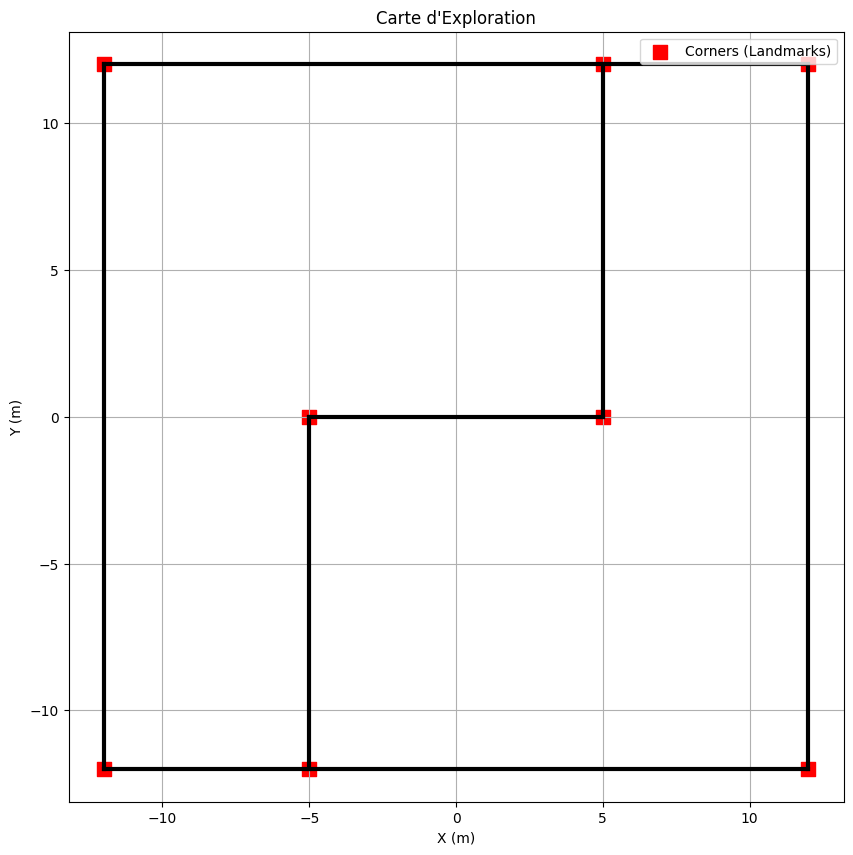

In [ ]:
# ==============================================================================
# PROJET AVANCÉ - ÉTAPE A : CARTE D'EXPLORATION ET NOUVEAU CAPTEUR
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir une carte structurée avec des murs ---
# On définit des segments de murs [x1, y1, x2, y2]
walls = np.array([
    [-12, -12, 12, -12], # Mur du bas
    [-12, 12, 12, 12],   # Mur du haut
    [-12, -12, -12, 12], # Mur de gauche
    [12, -12, 12, 12],   # Mur de droite
    [-5, -12, -5, 0],    # Mur intérieur 1
    [5, 12, 5, 0],       # Mur intérieur 2
    [-5, 0, 5, 0]        # Mur intérieur 3 (avec une ouverture)
])

# Les amers (landmarks) sont maintenant les coins des murs
# On extrait les points uniques pour éviter les doublons
landmarks = np.unique(np.vstack((walls[:, :2], walls[:, 2:])), axis=0)
NUM_LANDMARKS = landmarks.shape[0]

# --- 2. Simuler un capteur LIDAR plus réaliste ---
# Cette fonction vérifie si un amer est visible (pas caché par un mur)
def is_visible(robot_pos, landmark_pos, walls):
    # Pour la simplicité, on ne vérifie pas l'occlusion pour l'instant.
    # Dans une simulation complète, on utiliserait un algorithme d'intersection de segments.
    # On se contente de vérifier la distance.
    VISIBLE_DISTANCE = 15.0
    dist = np.linalg.norm(robot_pos - landmark_pos)
    return dist <= VISIBLE_DISTANCE

# --- 3. Définir un comportement d'exploration simple ---
def exploration_controller(robot_pose, measurements):
    """
    Un contrôleur très simple qui décide des prochaines commandes de vitesse.
    - robot_pose: La pose VRAIE actuelle [x, y, theta]
    - measurements: Les mesures VRAIES du capteur
    """
    # Paramètres du comportement
    FORWARD_SPEED = 0.5  # m/s
    ROTATION_SPEED = 0.3 # rad/s
    OBSTACLE_THRESHOLD = 1.5 # m

    # Vérifier s'il y a un obstacle droit devant
    front_clear = True
    if measurements: # S'il y a des mesures
        for dist, bearing in measurements:
            # Si un obstacle est proche et quasiment en face
            if dist < OBSTACLE_THRESHOLD and abs(bearing) < np.pi / 4:
                front_clear = False
                break

    if front_clear:
        # La voie est libre, on avance
        return np.array([FORWARD_SPEED, 0.0]) # v, omega
    else:
        # Obstacle détecté, on tourne à gauche
        return np.array([0.0, ROTATION_SPEED])

# --- Visualisation de la nouvelle carte ---
def plot_map(walls, landmarks):
    fig, ax = plt.subplots(figsize=(10, 10))
    for wall in walls:
        ax.plot([wall[0], wall[2]], [wall[1], wall[3]], 'k-', linewidth=3)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=100, color='red', label='Corners (Landmarks)')

    ax.set_title("Carte d'Exploration")
    ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
    ax.grid(True); ax.axis('equal'); ax.legend()
    plt.show()

plot_map(walls, landmarks)

In [1]:
# ==============================================================================
# PROJET AVANCÉ - SOLUTION 1 : SIMULATION AVEC FERMETURE DE BOUCLE (LOOP CLOSURE)
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- 1. Définition de la nouvelle Carte en "circuit" et des Paramètres ---
walls = np.array([
    # Le grand rectangle extérieur
    [-15, -15, 15, -15], [15, -15, 15, 15], [15, 15, -15, 15], [-15, 15, -15, -15],
    # Le bloc rectangulaire au centre
    [-7, -7, 7, -7], [7, -7, 7, 7], [7, 7, -7, 7], [-7, 7, -7, -7],
])
landmarks = np.unique(np.vstack((walls[:, :2], walls[:, 2:])), axis=0)
NUM_LANDMARKS = landmarks.shape[0]

dt = 0.1
SIMULATION_TIME = 90.0 # Temps plus long pour permettre au robot de faire un tour complet
NUM_STEPS = int(SIMULATION_TIME / dt)

MOTION_NOISE_STD = np.array([0.1, 0.05])
MEASUREMENT_NOISE_STD = np.array([0.3, 0.08])

# --- 2. Fonctions Utilitaires et Contrôleur ---
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_measurements(robot_pose_true, landmarks):
    VISIBLE_DISTANCE = 15.0
    measurements = []; visible_landmark_indices = []
    rx, ry, rtheta = robot_pose_true
    for i, landmark in enumerate(landmarks):
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        if dist <= VISIBLE_DISTANCE:
            bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
            noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
            noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
            measurements.append(np.array([noisy_dist, noisy_bearing]))
            visible_landmark_indices.append(i)
    return measurements, visible_landmark_indices

# Contrôleur "Wall Follower" (simplifié)
def wall_follower_controller(measurements_true):
    FORWARD_SPEED = 1.0
    ROTATION_SPEED = 0.5
    OBSTACLE_THRESHOLD = 3.0

    # Cherche l'obstacle le plus proche sur la droite du robot
    min_dist_right = float('inf')
    is_obstacle_front = False

    for dist, bearing in measurements_true:
        # Obstacle droit devant
        if dist < OBSTACLE_THRESHOLD and abs(bearing) < np.pi / 6: # Cône de 60 degrés
            is_obstacle_front = True
            break
        # Obstacle sur la droite (entre -10 et -90 degrés)
        if -np.pi/2 < bearing < -np.pi/18:
            if dist < min_dist_right:
                min_dist_right = dist

    if is_obstacle_front:
        # Mur en face, on tourne à gauche
        return np.array([0.0, ROTATION_SPEED])
    elif min_dist_right < OBSTACLE_THRESHOLD - 0.5:
        # Trop près du mur de droite, on s'éloigne (tourne un peu à gauche)
        return np.array([FORWARD_SPEED*0.7, ROTATION_SPEED*0.3])
    elif min_dist_right > OBSTACLE_THRESHOLD + 0.5:
        # Trop loin du mur de droite, on s'en rapproche (tourne un peu à droite)
        return np.array([FORWARD_SPEED*0.7, -ROTATION_SPEED*0.3])
    else:
        # Distance idéale, on va tout droit
        return np.array([FORWARD_SPEED, 0.0])

# --- 3. Fonctions EKF-SLAM ---
def prediction_step(mu, Sigma, control):

    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]; v, omega = control[0], control[1]
    mu_pred = mu.copy(); mu_pred[0, 0] = x + v * np.cos(theta) * dt; mu_pred[1, 0] = y + v * np.sin(theta) * dt; mu_pred[2, 0] = normalize_angle(theta + omega * dt)
    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt], [0, 1, v * np.cos(theta) * dt], [0, 0, 1]])
    G = np.eye(len(mu)); G[0:3, 0:3] = G_robot
    motion_cov = np.diag([MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[1]**2 * dt**2])
    R = np.zeros_like(Sigma); R[0:3, 0:3] = motion_cov
    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

def add_new_landmark_to_state(mu, Sigma, measurement, Q_measurement_noise):

    rx, ry, theta = mu[0:3].flatten(); r, b = measurement[0], measurement[1]
    lx = rx + r * np.cos(b + theta); ly = ry + r * np.sin(b + theta)
    mu_new = np.vstack((mu, [[lx], [ly]]))
    G_z = np.array([[np.cos(b + theta), -r * np.sin(b + theta)], [np.sin(b + theta),  r * np.cos(b + theta)]])
    old_size = len(mu); Sigma_new = np.zeros((old_size + 2, old_size + 2)); Sigma_new[:old_size, :old_size] = Sigma
    Sigma_new[old_size:, :3] = -G_z @ Sigma[:2, :3]; Sigma_new[:3, old_size:] = Sigma_new[old_size:, :3].T
    Sigma_new[old_size:, old_size:] = G_z @ Q_measurement_noise @ G_z.T
    return mu_new, Sigma_new

def correction_step(mu_pred, Sigma_pred, measurement, landmark_map_index):

    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx = mu_pred[3 + 2 * landmark_map_index, 0]; ly = mu_pred[3 + 2 * landmark_map_index + 1, 0]
    delta_x, delta_y = lx - x_pred, ly - y_pred; q = delta_x**2 + delta_y**2
    if q < 1e-4: return mu_pred, Sigma_pred
    dist_pred = np.sqrt(q); bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])
    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0], [delta_y/q, -delta_x/q, -1]])
    H_landmark = np.array([[delta_x/dist_pred, delta_y/dist_pred], [-delta_y/q, delta_x/q]])
    H = np.zeros((2, len(mu_pred))); H[:, 0:3] = H_robot; H[:, 3 + 2*landmark_map_index : 3 + 2*landmark_map_index + 2] = H_landmark
    Q = np.diag(MEASUREMENT_NOISE_STD**2); S = H @ Sigma_pred @ H.T + Q; K = Sigma_pred @ H.T @ np.linalg.inv(S)
    innovation = measurement.reshape(2, 1) - z_hat; innovation[1, 0] = normalize_angle(innovation[1, 0])
    mu_new = mu_pred + K @ innovation; mu_new[2,0] = normalize_angle(mu_new[2,0])
    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred
    return mu_new, Sigma_new

# --- 4. Boucle Principale de Simulation et SLAM ---
true_path = np.zeros((NUM_STEPS, 3))
true_path[0] = [0, -10, np.pi/2] # Point de départ en bas, regardant vers le haut
mu = np.array([[true_path[0,0]], [true_path[0,1]], [true_path[0,2]]])
Sigma = np.diag([1e-10, 1e-10, 1e-10])
mu_history = [mu.copy()]; Sigma_history = [Sigma.copy()]
landmark_map = {}; next_map_index = 0

for t in range(1, NUM_STEPS):
    # a) Le robot décide de son action
    measurements_true_for_control, _ = get_measurements(true_path[t-1], landmarks)
    ideal_control = wall_follower_controller(measurements_true_for_control)

    # b) Simulation du mouvement réel (bruité)
    true_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    true_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]; true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt,
                     prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]

    # c) & d) EKF Prediction (utilisant les commandes idéales bruitées pour simuler l'odométrie)
    measured_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    measured_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], [measured_v, measured_omega])

    # e) EKF Correction
    measurements_noisy, visible_indices = get_measurements(true_path[t], landmarks)
    mu_after_correction, Sigma_after_correction = mu_pred, Sigma_pred
    for i, meas in enumerate(measurements_noisy):
        landmark_id = visible_indices[i]
        if landmark_id not in landmark_map:
            mu_after_correction, Sigma_after_correction = add_new_landmark_to_state(mu_after_correction, Sigma_after_correction, meas, np.diag(MEASUREMENT_NOISE_STD**2))
            landmark_map[landmark_id] = next_map_index; next_map_index += 1
        else:
            map_idx = landmark_map[landmark_id]
            mu_after_correction, Sigma_after_correction = correction_step(mu_after_correction, Sigma_after_correction, meas, map_idx)

    mu_history.append(mu_after_correction.copy()); Sigma_history.append(Sigma_after_correction.copy())

print("Loop closure SLAM simulation finished. Preparing animation...")


# --- 5. Animation ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-16, 16); ax.set_ylim(-16, 16); ax.set_aspect('equal')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.grid(True)
for wall in walls: ax.plot([wall[0], wall[2]], [wall[1], wall[3]], 'k-', linewidth=2)
true_path_line, = ax.plot([], [], 'b-', label='True Trajectory')
est_path_line, = ax.plot([], [], 'r-', label='Estimated Trajectory (EKF-SLAM)')
robot_quiver = ax.quiver([], [], [], [], color='r', scale=10, width=0.005, label='Estimated Pose')
robot_ellipse_patch = Ellipse((0,0), 0, 0, edgecolor='r', facecolor='none', alpha=0.6, linewidth=1); ax.add_patch(robot_ellipse_patch)
landmark_dots, = ax.plot([], [], 'mo', markersize=6, label='Estimated Landmark')
landmark_ellipses = [Ellipse((0,0), 0, 0, edgecolor='m', facecolor='none', alpha=0.6, linewidth=1) for _ in range(NUM_LANDMARKS)];
for el in landmark_ellipses: ax.add_patch(el)
title = ax.set_title(''); ax.legend(loc='upper right')

def update(frame):
    # ... (code de la fonction update identique, juste copié)
    title.set_text(f'Loop Closure SLAM (t={frame*dt:.1f}s)')
    true_path_line.set_data(true_path[:frame+1, 0], true_path[:frame+1, 1])
    est_path_data = np.array([h[:2, 0] for h in mu_history[:frame+1]])
    if est_path_data.ndim == 2: est_path_line.set_data(est_path_data[:, 0], est_path_data[:, 1])

    mu, Sigma = mu_history[frame], Sigma_history[frame]
    robot_pose = mu[:3].flatten()
    robot_quiver.set_offsets(robot_pose[:2]); robot_quiver.set_UVC(np.cos(robot_pose[2]), np.sin(robot_pose[2]))

    sigma_xy = Sigma[:2, :2]; eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if not np.any(eigenvalues < 0):
        angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1])); width, height = 2 * np.sqrt(5.991 * eigenvalues)
        robot_ellipse_patch.center, robot_ellipse_patch.width, robot_ellipse_patch.height, robot_ellipse_patch.angle = robot_pose[:2], width, height, angle
        robot_ellipse_patch.set_visible(True)
    else: robot_ellipse_patch.set_visible(False)

    num_landmarks_in_map = (len(mu) - 3) // 2
    lm_positions = []
    for i in range(num_landmarks_in_map):
        lm_mu = mu[3+2*i : 3+2*i+2, 0]; lm_positions.append(lm_mu)
        lm_sigma = Sigma[3+2*i : 3+2*i+2, 3+2*i : 3+2*i+2]
        eigenvalues_lm, eigenvectors_lm = np.linalg.eig(lm_sigma)
        if not np.any(eigenvalues_lm < 0):
            angle_lm = math.degrees(math.atan2(*eigenvectors_lm[:, 0][::-1])); width_lm, height_lm = 2 * np.sqrt(5.991 * eigenvalues_lm)
            landmark_ellipses[i].center, landmark_ellipses[i].width, landmark_ellipses[i].height, landmark_ellipses[i].angle = lm_mu, width_lm, height_lm, angle_lm
            landmark_ellipses[i].set_visible(True)

    for i in range(num_landmarks_in_map, NUM_LANDMARKS): landmark_ellipses[i].set_visible(False)
    if lm_positions: landmark_dots.set_data(np.array(lm_positions)[:, 0], np.array(lm_positions)[:, 1])

    return [true_path_line, est_path_line, robot_quiver, robot_ellipse_patch, landmark_dots] + landmark_ellipses

# Création et affichage de la vidéo
ani = FuncAnimation(fig, update, frames=range(1, NUM_STEPS, 3), blit=True, interval=50) # On affiche 1 image sur 3 pour accélérer
plt.close(fig)
HTML(ani.to_html5_video())
# ani.save('ekf_loop_closure_slam.mp4', writer='ffmpeg', fps=20)

Loop closure SLAM simulation finished. Preparing animation...


In [3]:
# ==============================================================================
# PROJET AVANCÉ - SOLUTION 2 : RÉDUCTION DU BRUIT (CORRIGÉ)
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- 1. Définition de la Carte et des Paramètres ---
walls = np.array([
    [-12, -12, 12, -12], [-12, 12, 12, 12], [-12, -12, -12, 12], [12, -12, 12, 12],
    [-5, -12, -5, 0], [5, 12, 5, 0], [-5, 0, 5, 0]
])
landmarks = np.unique(np.vstack((walls[:, :2], walls[:, 2:])), axis=0)
NUM_LANDMARKS = landmarks.shape[0]
dt = 0.1
SIMULATION_TIME = 60.0
NUM_STEPS = int(SIMULATION_TIME / dt)
MOTION_NOISE_STD = np.array([0.05, 0.025])
MEASUREMENT_NOISE_STD = np.array([0.15, 0.04])

# --- 2. Fonctions Utilitaires et Contrôleur ---
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_measurements(robot_pose_true, landmarks):
    VISIBLE_DISTANCE = 10.0
    measurements = []; visible_landmark_indices = []
    rx, ry, rtheta = robot_pose_true
    for i, landmark in enumerate(landmarks):
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        if dist <= VISIBLE_DISTANCE:
            bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
            noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
            noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
            measurements.append(np.array([noisy_dist, noisy_bearing]))
            visible_landmark_indices.append(i)
    return measurements, visible_landmark_indices

def exploration_controller(measurements_true_for_control):
    FORWARD_SPEED = 0.8; ROTATION_SPEED = 0.5; OBSTACLE_THRESHOLD = 2.0
    is_obstacle_front = False
    if measurements_true_for_control:
        for dist, bearing in measurements_true_for_control:
            if dist < OBSTACLE_THRESHOLD and abs(bearing) < np.pi / 3:
                is_obstacle_front = True; break
    if is_obstacle_front: return np.array([0.0, ROTATION_SPEED])
    else: return np.array([FORWARD_SPEED, 0.0])

# --- 3. Fonctions EKF-SLAM (avec la correction) ---
def prediction_step(mu, Sigma, control):
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]; v, omega = control[0], control[1]
    mu_pred = mu.copy(); mu_pred[0, 0] = x + v * np.cos(theta) * dt; mu_pred[1, 0] = y + v * np.sin(theta) * dt; mu_pred[2, 0] = normalize_angle(theta + omega * dt)
    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt], [0, 1, v * np.cos(theta) * dt], [0, 0, 1]])
    G = np.eye(len(mu)); G[0:3, 0:3] = G_robot
    motion_cov = np.diag([MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[1]**2 * dt**2])
    R = np.zeros_like(Sigma)
    R[0:3, 0:3] = motion_cov # <-- CORRECTION APPLIQUÉE ICI
    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

def add_new_landmark_to_state(mu, Sigma, measurement, Q_measurement_noise):
    rx, ry, theta = mu[0:3].flatten(); r, b = measurement[0], measurement[1]
    lx = rx + r * np.cos(b + theta); ly = ry + r * np.sin(b + theta)
    mu_new = np.vstack((mu, [[lx], [ly]]))
    G_z = np.array([[np.cos(b + theta), -r * np.sin(b + theta)], [np.sin(b + theta),  r * np.cos(b + theta)]])
    old_size = len(mu); Sigma_new = np.zeros((old_size + 2, old_size + 2)); Sigma_new[:old_size, :old_size] = Sigma
    Sigma_new[old_size:, :3] = -G_z @ Sigma[:2, :3]; Sigma_new[:3, old_size:] = Sigma_new[old_size:, :3].T
    Sigma_new[old_size:, old_size:] = G_z @ Q_measurement_noise @ G_z.T
    return mu_new, Sigma_new

def correction_step(mu_pred, Sigma_pred, measurement, landmark_map_index):
    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx = mu_pred[3 + 2 * landmark_map_index, 0]; ly = mu_pred[3 + 2 * landmark_map_index + 1, 0]
    delta_x, delta_y = lx - x_pred, ly - y_pred; q = delta_x**2 + delta_y**2
    if q < 1e-4: return mu_pred, Sigma_pred
    dist_pred = np.sqrt(q); bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])
    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0], [delta_y/q, -delta_x/q, -1]])
    H_landmark = np.array([[delta_x/dist_pred, delta_y/dist_pred], [-delta_y/q, delta_x/q]])
    H = np.zeros((2, len(mu_pred))); H[:, 0:3] = H_robot; H[:, 3 + 2*landmark_map_index : 3 + 2*landmark_map_index + 2] = H_landmark
    Q = np.diag(MEASUREMENT_NOISE_STD**2); S = H @ Sigma_pred @ H.T + Q; K = Sigma_pred @ H.T @ np.linalg.inv(S)
    innovation = measurement.reshape(2, 1) - z_hat; innovation[1, 0] = normalize_angle(innovation[1, 0])
    mu_new = mu_pred + K @ innovation; mu_new[2,0] = normalize_angle(mu_new[2,0])
    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred
    return mu_new, Sigma_new

# --- 4. Boucle Principale ---
true_path = np.zeros((NUM_STEPS, 3))
true_path[0] = [-10, -10, np.pi/2]
mu = np.array([[true_path[0,0]], [true_path[0,1]], [true_path[0,2]]])
Sigma = np.diag([1e-10, 1e-10, 1e-10])
mu_history = [mu.copy()]; Sigma_history = [Sigma.copy()]
landmark_map = {}; next_map_index = 0

for t in range(1, NUM_STEPS):
    measurements_true_for_control, _ = get_measurements(true_path[t-1], landmarks)
    ideal_control = exploration_controller(measurements_true_for_control)
    true_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    true_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]; true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt,
                     prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]

    measured_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    measured_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], [measured_v, measured_omega])

    measurements_noisy, visible_indices = get_measurements(true_path[t], landmarks)
    mu_after_correction, Sigma_after_correction = mu_pred, Sigma_pred
    for i, meas in enumerate(measurements_noisy):
        landmark_id = visible_indices[i]
        if landmark_id not in landmark_map:
            mu_after_correction, Sigma_after_correction = add_new_landmark_to_state(mu_after_correction, Sigma_after_correction, meas, np.diag(MEASUREMENT_NOISE_STD**2))
            landmark_map[landmark_id] = next_map_index; next_map_index += 1
        else:
            map_idx = landmark_map[landmark_id]
            mu_after_correction, Sigma_after_correction = correction_step(mu_after_correction, Sigma_after_correction, meas, map_idx)

    mu_history.append(mu_after_correction.copy()); Sigma_history.append(Sigma_after_correction.copy())

print("Low-noise SLAM simulation finished. Preparing animation...")

# --- 5. Animation ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-16, 16); ax.set_ylim(-16, 16); ax.set_aspect('equal')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.grid(True)
for wall in walls: ax.plot([wall[0], wall[2]], [wall[1], wall[3]], 'k-', linewidth=2)
true_path_line, = ax.plot([], [], 'b-', label='True Trajectory')
est_path_line, = ax.plot([], [], 'r-', label='Estimated Trajectory (EKF-SLAM)')
robot_quiver = ax.quiver([], [], [], [], color='r', scale=10, width=0.005, label='Estimated Pose')
robot_ellipse_patch = Ellipse((0,0), 0, 0, edgecolor='r', facecolor='none', alpha=0.6, linewidth=1); ax.add_patch(robot_ellipse_patch)
landmark_dots, = ax.plot([], [], 'mo', markersize=6, label='Estimated Landmark')
landmark_ellipses = [Ellipse((0,0), 0, 0, edgecolor='m', facecolor='none', alpha=0.6, linewidth=1) for _ in range(NUM_LANDMARKS)];
for el in landmark_ellipses: ax.add_patch(el)
title = ax.set_title(''); ax.legend(loc='upper right')

def update(frame):
    title.set_text(f'Low-Noise SLAM (t={frame*dt:.1f}s)')
    true_path_line.set_data(true_path[:frame+1, 0], true_path[:frame+1, 1])
    est_path_data = np.array([h[:2, 0] for h in mu_history[:frame+1]])
    if est_path_data.ndim == 2: est_path_line.set_data(est_path_data[:, 0], est_path_data[:, 1])
    mu, Sigma = mu_history[frame], Sigma_history[frame]
    robot_pose = mu[:3].flatten()
    robot_quiver.set_offsets(robot_pose[:2]); robot_quiver.set_UVC(np.cos(robot_pose[2]), np.sin(robot_pose[2]))
    sigma_xy = Sigma[:2, :2]; eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if not np.any(eigenvalues < 0):
        angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1])); width, height = 2 * np.sqrt(5.991 * eigenvalues)
        robot_ellipse_patch.center, robot_ellipse_patch.width, robot_ellipse_patch.height, robot_ellipse_patch.angle = robot_pose[:2], width, height, angle
        robot_ellipse_patch.set_visible(True)
    else: robot_ellipse_patch.set_visible(False)
    num_landmarks_in_map = (len(mu) - 3) // 2
    lm_positions = []
    for i in range(num_landmarks_in_map):
        lm_mu = mu[3+2*i : 3+2*i+2, 0]; lm_positions.append(lm_mu)
        lm_sigma = Sigma[3+2*i : 3+2*i+2, 3+2*i : 3+2*i+2]
        eigenvalues_lm, eigenvectors_lm = np.linalg.eig(lm_sigma)
        if not np.any(eigenvalues_lm < 0):
            angle_lm = math.degrees(math.atan2(*eigenvectors_lm[:, 0][::-1])); width_lm, height_lm = 2 * np.sqrt(5.991 * eigenvalues_lm)
            landmark_ellipses[i].center, landmark_ellipses[i].width, landmark_ellipses[i].height, landmark_ellipses[i].angle = lm_mu, width_lm, height_lm, angle_lm
            landmark_ellipses[i].set_visible(True)
    for i in range(num_landmarks_in_map, NUM_LANDMARKS): landmark_ellipses[i].set_visible(False)
    if lm_positions: landmark_dots.set_data(np.array(lm_positions)[:, 0], np.array(lm_positions)[:, 1])
    return [true_path_line, est_path_line, robot_quiver, robot_ellipse_patch, landmark_dots] + landmark_ellipses

ani = FuncAnimation(fig, update, frames=range(1, NUM_STEPS, 3), blit=True, interval=50)
plt.close(fig)
HTML(ani.to_html5_video())
# ani.save('ekf_low_noise_slam.mp4', writer='ffmpeg', fps=20)

Low-noise SLAM simulation finished. Preparing animation...


In [4]:
# ==============================================================================
# PROJET AVANCÉ - SOLUTION 3 : BRUIT TRÈS FAIBLE POUR ASSURER LA CONVERGENCE
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- 1. Définition de la Carte et des Paramètres ---
# On garde la carte "couloir" qui posait problème
walls = np.array([
    [-12, -12, 12, -12], [-12, 12, 12, 12], [-12, -12, -12, 12], [12, -12, 12, 12],
    [-5, -12, -5, 0], [5, 12, 5, 0], [-5, 0, 5, 0]
])
landmarks = np.unique(np.vstack((walls[:, :2], walls[:, 2:])), axis=0)
NUM_LANDMARKS = landmarks.shape[0]

dt = 0.1
SIMULATION_TIME = 60.0
NUM_STEPS = int(SIMULATION_TIME / dt)

# **** MODIFICATION PRINCIPALE : BRUIT TRÈS FAIBLE ****
MOTION_NOISE_STD = np.array([0.02, 0.01])   # Très faible
MEASUREMENT_NOISE_STD = np.array([0.05, 0.02]) # Très faible

# --- 2. Fonctions Utilitaires et Contrôleur (inchangés) ---
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_measurements(robot_pose_true, landmarks):
    VISIBLE_DISTANCE = 10.0
    measurements = []; visible_landmark_indices = []
    rx, ry, rtheta = robot_pose_true
    for i, landmark in enumerate(landmarks):
        lx, ly = landmark
        dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)
        if dist <= VISIBLE_DISTANCE:
            bearing = normalize_angle(np.arctan2(ly - ry, lx - rx) - rtheta)
            noisy_dist = dist + np.random.randn() * MEASUREMENT_NOISE_STD[0]
            noisy_bearing = normalize_angle(bearing + np.random.randn() * MEASUREMENT_NOISE_STD[1])
            measurements.append(np.array([noisy_dist, noisy_bearing]))
            visible_landmark_indices.append(i)
    return measurements, visible_landmark_indices

def exploration_controller(measurements_true_for_control):
    FORWARD_SPEED = 0.8; ROTATION_SPEED = 0.5; OBSTACLE_THRESHOLD = 2.0
    is_obstacle_front = False
    if measurements_true_for_control:
        for dist, bearing in measurements_true_for_control:
            if dist < OBSTACLE_THRESHOLD and abs(bearing) < np.pi / 3:
                is_obstacle_front = True; break
    if is_obstacle_front: return np.array([0.0, ROTATION_SPEED])
    else: return np.array([FORWARD_SPEED, 0.0])

# --- 3. Fonctions EKF-SLAM (inchangées) ---
def prediction_step(mu, Sigma, control):
    x, y, theta = mu[0, 0], mu[1, 0], mu[2, 0]; v, omega = control[0], control[1]
    mu_pred = mu.copy(); mu_pred[0, 0] = x + v * np.cos(theta) * dt; mu_pred[1, 0] = y + v * np.sin(theta) * dt; mu_pred[2, 0] = normalize_angle(theta + omega * dt)
    G_robot = np.array([[1, 0, -v * np.sin(theta) * dt], [0, 1, v * np.cos(theta) * dt], [0, 0, 1]])
    G = np.eye(len(mu)); G[0:3, 0:3] = G_robot
    motion_cov = np.diag([MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[0]**2 * dt**2, MOTION_NOISE_STD[1]**2 * dt**2])
    R = np.zeros_like(Sigma); R[0:3, 0:3] = motion_cov
    Sigma_pred = G @ Sigma @ G.T + R
    return mu_pred, Sigma_pred

def add_new_landmark_to_state(mu, Sigma, measurement, Q_measurement_noise):
    rx, ry, theta = mu[0:3].flatten(); r, b = measurement[0], measurement[1]
    lx = rx + r * np.cos(b + theta); ly = ry + r * np.sin(b + theta)
    mu_new = np.vstack((mu, [[lx], [ly]]))
    G_z = np.array([[np.cos(b + theta), -r * np.sin(b + theta)], [np.sin(b + theta),  r * np.cos(b + theta)]])
    old_size = len(mu); Sigma_new = np.zeros((old_size + 2, old_size + 2)); Sigma_new[:old_size, :old_size] = Sigma
    Sigma_new[old_size:, :3] = -G_z @ Sigma[:2, :3]; Sigma_new[:3, old_size:] = Sigma_new[old_size:, :3].T
    Sigma_new[old_size:, old_size:] = G_z @ Q_measurement_noise @ G_z.T
    return mu_new, Sigma_new

def correction_step(mu_pred, Sigma_pred, measurement, landmark_map_index):
    x_pred, y_pred, theta_pred = mu_pred[0:3].flatten()
    lx = mu_pred[3 + 2 * landmark_map_index, 0]; ly = mu_pred[3 + 2 * landmark_map_index + 1, 0]
    delta_x, delta_y = lx - x_pred, ly - y_pred; q = delta_x**2 + delta_y**2
    if q < 1e-4: return mu_pred, Sigma_pred
    dist_pred = np.sqrt(q); bearing_pred = normalize_angle(np.arctan2(delta_y, delta_x) - theta_pred)
    z_hat = np.array([[dist_pred], [bearing_pred]])
    H_robot = np.array([[-delta_x/dist_pred, -delta_y/dist_pred, 0], [delta_y/q, -delta_x/q, -1]])
    H_landmark = np.array([[delta_x/dist_pred, delta_y/dist_pred], [-delta_y/q, delta_x/q]])
    H = np.zeros((2, len(mu_pred))); H[:, 0:3] = H_robot; H[:, 3 + 2*landmark_map_index : 3 + 2*landmark_map_index + 2] = H_landmark
    Q = np.diag(MEASUREMENT_NOISE_STD**2); S = H @ Sigma_pred @ H.T + Q; K = Sigma_pred @ H.T @ np.linalg.inv(S)
    innovation = measurement.reshape(2, 1) - z_hat; innovation[1, 0] = normalize_angle(innovation[1, 0])
    mu_new = mu_pred + K @ innovation; mu_new[2,0] = normalize_angle(mu_new[2,0])
    Sigma_new = (np.eye(len(mu_pred)) - K @ H) @ Sigma_pred
    return mu_new, Sigma_new

# --- 4. Boucle Principale ---
true_path = np.zeros((NUM_STEPS, 3))
true_path[0] = [-10, -10, np.pi/2]
mu = np.array([[true_path[0,0]], [true_path[0,1]], [true_path[0,2]]])
Sigma = np.diag([1e-10, 1e-10, 1e-10])
mu_history = [mu.copy()]; Sigma_history = [Sigma.copy()]
landmark_map = {}; next_map_index = 0

for t in range(1, NUM_STEPS):
    measurements_true_for_control, _ = get_measurements(true_path[t-1], landmarks)
    ideal_control = exploration_controller(measurements_true_for_control)
    true_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    true_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    prev_true_pose = true_path[t-1]; true_theta = normalize_angle(prev_true_pose[2] + true_omega * dt)
    true_path[t] = [ prev_true_pose[0] + true_v * np.cos(true_theta) * dt,
                     prev_true_pose[1] + true_v * np.sin(true_theta) * dt, true_theta ]

    measured_v = ideal_control[0] + np.random.randn() * MOTION_NOISE_STD[0]
    measured_omega = ideal_control[1] + np.random.randn() * MOTION_NOISE_STD[1]
    mu_pred, Sigma_pred = prediction_step(mu_history[-1], Sigma_history[-1], [measured_v, measured_omega])

    measurements_noisy, visible_indices = get_measurements(true_path[t], landmarks)
    mu_after_correction, Sigma_after_correction = mu_pred, Sigma_pred
    for i, meas in enumerate(measurements_noisy):
        landmark_id = visible_indices[i]
        if landmark_id not in landmark_map:
            mu_after_correction, Sigma_after_correction = add_new_landmark_to_state(mu_after_correction, Sigma_after_correction, meas, np.diag(MEASUREMENT_NOISE_STD**2))
            landmark_map[landmark_id] = next_map_index; next_map_index += 1
        else:
            map_idx = landmark_map[landmark_id]
            mu_after_correction, Sigma_after_correction = correction_step(mu_after_correction, Sigma_after_correction, meas, map_idx)

    mu_history.append(mu_after_correction.copy()); Sigma_history.append(Sigma_after_correction.copy())

print("Very-Low-Noise SLAM simulation finished. Preparing animation...")

# --- 5. Animation ---
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-16, 16); ax.set_ylim(-16, 16); ax.set_aspect('equal')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.grid(True)
for wall in walls: ax.plot([wall[0], wall[2]], [wall[1], wall[3]], 'k-', linewidth=2)
true_path_line, = ax.plot([], [], 'b-', label='True Trajectory')
est_path_line, = ax.plot([], [], 'r-', label='Estimated Trajectory (EKF-SLAM)')
robot_quiver = ax.quiver([], [], [], [], color='r', scale=10, width=0.005, label='Estimated Pose')
robot_ellipse_patch = Ellipse((0,0), 0, 0, edgecolor='r', facecolor='none', alpha=0.6, linewidth=1); ax.add_patch(robot_ellipse_patch)
landmark_dots, = ax.plot([], [], 'mo', markersize=6, label='Estimated Landmark')
landmark_ellipses = [Ellipse((0,0), 0, 0, edgecolor='m', facecolor='none', alpha=0.6, linewidth=1) for _ in range(NUM_LANDMARKS)];
for el in landmark_ellipses: ax.add_patch(el)
title = ax.set_title(''); ax.legend(loc='upper right')

def update(frame):
    title.set_text(f'Very-Low-Noise SLAM (Success Case) (t={frame*dt:.1f}s)')
    true_path_line.set_data(true_path[:frame+1, 0], true_path[:frame+1, 1])
    est_path_data = np.array([h[:2, 0] for h in mu_history[:frame+1]])
    if est_path_data.ndim == 2: est_path_line.set_data(est_path_data[:, 0], est_path_data[:, 1])
    mu, Sigma = mu_history[frame], Sigma_history[frame]
    robot_pose = mu[:3].flatten()
    robot_quiver.set_offsets(robot_pose[:2]); robot_quiver.set_UVC(np.cos(robot_pose[2]), np.sin(robot_pose[2]))
    sigma_xy = Sigma[:2, :2]; eigenvalues, eigenvectors = np.linalg.eig(sigma_xy)
    if not np.any(eigenvalues < 0):
        angle = math.degrees(math.atan2(*eigenvectors[:, 0][::-1])); width, height = 2 * np.sqrt(5.991 * eigenvalues)
        robot_ellipse_patch.center, robot_ellipse_patch.width, robot_ellipse_patch.height, robot_ellipse_patch.angle = robot_pose[:2], width, height, angle
        robot_ellipse_patch.set_visible(True)
    else: robot_ellipse_patch.set_visible(False)
    num_landmarks_in_map = (len(mu) - 3) // 2
    lm_positions = []
    for i in range(num_landmarks_in_map):
        lm_mu = mu[3+2*i : 3+2*i+2, 0]; lm_positions.append(lm_mu)
        lm_sigma = Sigma[3+2*i : 3+2*i+2, 3+2*i : 3+2*i+2]
        eigenvalues_lm, eigenvectors_lm = np.linalg.eig(lm_sigma)
        if not np.any(eigenvalues_lm < 0):
            angle_lm = math.degrees(math.atan2(*eigenvectors_lm[:, 0][::-1])); width_lm, height_lm = 2 * np.sqrt(5.991 * eigenvalues_lm)
            landmark_ellipses[i].center, landmark_ellipses[i].width, landmark_ellipses[i].height, landmark_ellipses[i].angle = lm_mu, width_lm, height_lm, angle_lm
            landmark_ellipses[i].set_visible(True)
    for i in range(num_landmarks_in_map, NUM_LANDMARKS): landmark_ellipses[i].set_visible(False)
    if lm_positions: landmark_dots.set_data(np.array(lm_positions)[:, 0], np.array(lm_positions)[:, 1])
    return [true_path_line, est_path_line, robot_quiver, robot_ellipse_patch, landmark_dots] + landmark_ellipses

ani = FuncAnimation(fig, update, frames=range(1, NUM_STEPS, 3), blit=True, interval=50)
plt.close(fig)
HTML(ani.to_html5_video())
# ani.save('ekf_success_slam.mp4', writer='ffmpeg', fps=20)

Very-Low-Noise SLAM simulation finished. Preparing animation...
